In [23]:
### Imports
import xarray as xr
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import signal
from scipy.signal import detrend
import random
from scipy.stats import norm
import re
### Nice plots
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgb
from matplotlib.gridspec import GridSpec
import seaborn as sns

In [3]:
def fit_ols(X, y):
    """OLS with MLE sigma^2 and Gaussian log-likelihood."""
    beta = np.linalg.lstsq(X, y, rcond=None)[0]
    resid = y - X @ beta
    n = y.size
    rss = float(resid @ resid)
    sigma2_mle = rss / n
    ll = -0.5 * n * (np.log(2 * np.pi * sigma2_mle) + 1.0)  # Gaussian i.i.d.
    return beta, ll, rss

### Interpretation of Bayes Factors
def interpret_bayes_factor(BF,model1_name='H1', model2_name='H0'):
    if 1 <= BF < 3:
        return "Anecdotal evidence for " + model1_name 
    elif 3 <= BF < 10:
        return "Substantial evidence for " + model1_name
    elif 10 <= BF < 30:
        return "Strong evidence for " + model1_name
    elif 30 <= BF < 100:
        return "Very strong evidence for " + model1_name
    ### Now the same with 1/BF
    elif BF >= 100:
        return "Decisive evidence for " + model1_name
    elif 1/3 < BF < 1:
        return "Anecdotal evidence for " + model2_name 
    elif 1/10 < BF <= 1/3:
        return "Substantial evidence for " + model2_name
    elif 1/30 < BF <= 1/10:
        return "Strong evidence for " + model2_name
    elif 1/100 < BF <= 1/30:
        return "Very strong evidence for " + model2_name
    elif BF <= 1/100:
        return "Decisive evidence for " + model2_name
    else:
        return "No evidence"

In [4]:

import urllib.request

# URL of the data file
url = "https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT5.0Analysis_gl.txt"

# Fetch the data from the URL
with urllib.request.urlopen(url) as response:
    lines = response.read().decode('utf-8').splitlines()

# Parse the lines to extract the data
data = []
months = []
years = []
for line in lines[::2]:
    values = line.split(' ')[2:-1]
    years.append(line.split(' ')[0])
    years.append(line.split(' ')[1])
    for i, value in enumerate(values):
        if value != '':
            data.append(value)
            months.append(i)

# Convert the list of lists into a NumPy array
data_array = np.array(data, dtype=float)
data_array = data_array

# Print the resulting NumPy array
print(data_array)

time = pd.date_range(start='1850-01-01', end='2024-12-01', freq='MS')
temperature_data = xr.DataArray(
    data_array[:-12], 
    coords={'time': time}, 
    dims='time', 
    name='temperature - HadCRU5'
)


[-0.734 -0.36  -0.627 ... -9.999 -9.999 -9.999]


In [5]:
def ols(X, y):
    # plain OLS with lstsq
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    return beta

In [6]:
### Including ENSO as a covariate
oni_path = '/home/jmindlin/BF_codes/data/oni_data.txt'

def load_oni_xarray(src):
    # Adjust reading logic to your file; this mirrors your approach.
    df_oni = np.loadtxt(src, skiprows=1, max_rows=76)
    oni = np.concatenate([df_oni[i, 1:13].flatten() for i in range(df_oni.shape[0]-1)])
    t_monthly = pd.date_range('1950-01-01', '2025-01-01', freq='ME')
    da = xr.DataArray(
        oni, dims=["time"], coords={"time": t_monthly}, name="oni",
        attrs={"units": "degC", "source": "NOAA"}
    )
    return da

oni = load_oni_xarray(oni_path)
oni_annual = oni.sel(time=slice("1979","2009")).groupby('time.year').mean(dim='time')  # annual mean 1950–2024
oni_years = oni_annual['year'].values.astype(int)
oni_vals = oni_annual.values

In [7]:
temp_data_hadCRUT3_old = xr.open_dataset('/home/jmindlin/BF_codes/data/HadCRUT3_archive_dec_2009.nc')
temp_hadCRUT3 = temp_data_hadCRUT3_old.mean(dim='latitude').mean(dim='longitude').temp

In [8]:
temp_data_hadCRUT3_corrected = xr.open_dataset('/home/jmindlin/BF_codes/data/HadCRUT3.nc')
temp_hadCRUT3_corrected = temp_data_hadCRUT3_corrected.mean(dim='latitude').mean(dim='longitude').temp

In [9]:
### Color list 
dark_oranges = sns.color_palette("Oranges", n_colors=15)[4:]
dark_purples = sns.color_palette("Purples", n_colors=9)[4:]
dark_greens = sns.color_palette("Greens", n_colors=9)[4:]

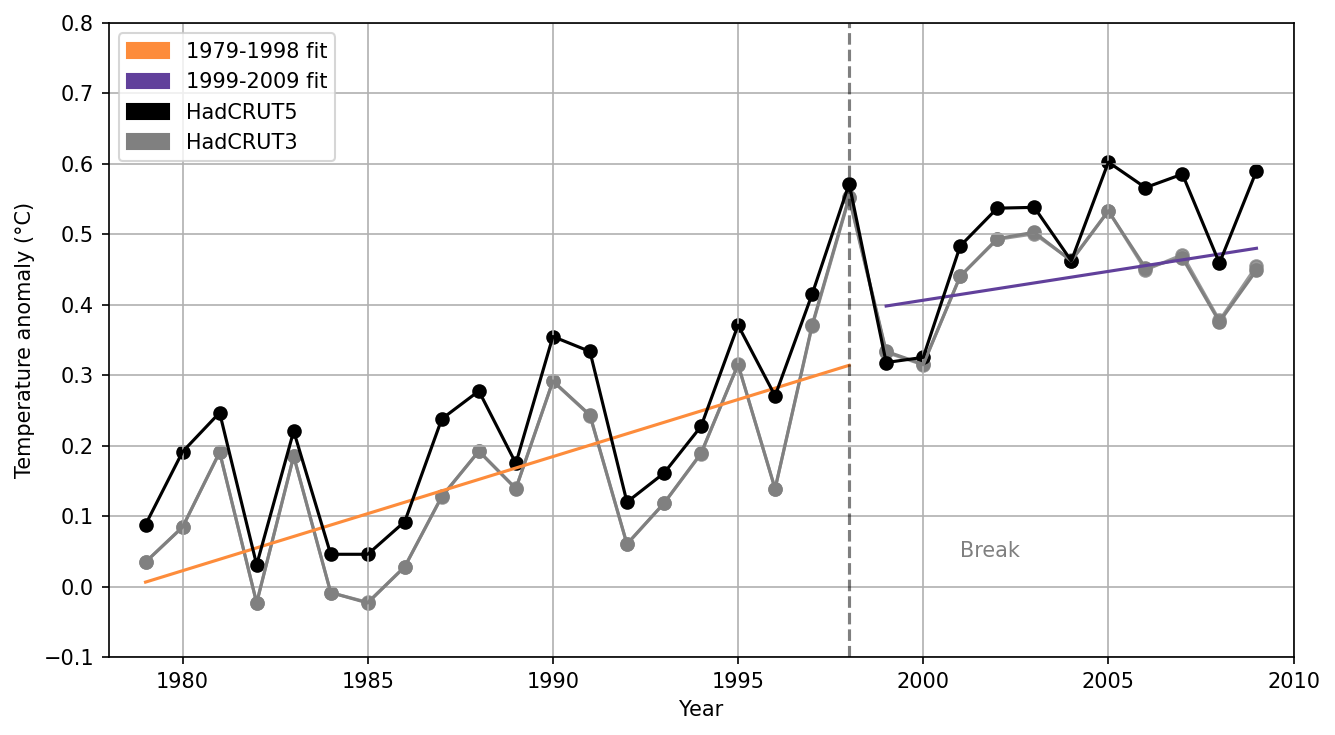

In [10]:
### HadCRUT3 old
temp = temp_hadCRUT3.sel(t=slice('1979','2009')).groupby('t.year').mean('t').values.reshape([-1])
years = temp_hadCRUT3.sel(t=slice('1979','2009')).groupby('t.year').mean('t').year.values
# 3) Fit and compute log-likelihoods
X0 = np.column_stack([np.ones(len(years[:20])), years[:20]])
beta0, ll0, rss0 = fit_ols(X0, temp[:20])
X1 = np.column_stack([np.ones(len(years[20:])), years[20:]])
beta1, ll1, rss1 = fit_ols(X1,temp[20:])

### HadCRUT3 corrected
temp_corr = temp_hadCRUT3_corrected.sel(t=slice('1979','2009')).groupby('t.year').mean('t').values.reshape([-1])
years = temp_hadCRUT3_corrected.sel(t=slice('1979','2009')).groupby('t.year').mean('t').year.values
# 3) Fit and compute log-likelihoods
X0 = np.column_stack([np.ones(len(years[:20])), years[:20]])
beta0_corr, ll0_corr, rss0_corr = fit_ols(X0, temp[:20])
X1 = np.column_stack([np.ones(len(years[20:])), years[20:]])
beta1_corr, ll1_corr, rss1_corr = fit_ols(X1,temp[20:])

### HadCRUT5 (in temperature_data)
da_year = (
    temperature_data
    .sel(time=slice("1979","2009"))
    .groupby("time.year").mean("time")
)
temp_hadCRUT5 = da_year.values.astype(float)
t_year = da_year.year.values.astype(float)
### repeat code for HadCRUT3
X0 = np.column_stack([np.ones(len(t_year[:20])), t_year[:20]])
beta0_hadCRUT5, ll0_hadCRUT5, rss0_hadCRUT5 = fit_ols(X0, temp_hadCRUT5[:20])
X1 = np.column_stack([np.ones(len(t_year[20:])), t_year[20:]])
beta1_hadCRUT5, ll1_hadCRUT5, rss1_hadCRUT5 = fit_ols(X1,temp_hadCRUT5[20:])


### Plot HadCRUT3 old and corrected with the individual fits

plt.figure(figsize=(9,5),dpi=150)
plt.plot(years,temp,color='grey', label='HadCRUT3 (old)' ,alpha=0.8)
plt.scatter(years,temp,color='grey',alpha=0.8)


plt.plot(years,temp_corr,color='grey', label='HadCRUT3 (corrected)')
plt.scatter(years,temp_corr,color='grey')
plt.plot(years[:20],X0@beta0_corr,color=dark_oranges[3])
plt.plot(years[20:],X1@beta1_corr,color=dark_purples[3])

#add hadCRUT5
plt.plot(t_year,temp_hadCRUT5,color='k',label='HadCRUT5')
plt.scatter(t_year,temp_hadCRUT5,color='k')

#Legend
red_patch = mpatches.Patch(color=dark_oranges[3], label='1979-1998 fit')
blue_patch = mpatches.Patch(color=dark_purples[3], label='1999-2009 fit')
data_patch = mpatches.Patch(color='k', label='HadCRUT5')
### Add HadCRUT3 pathches
grey_patch = mpatches.Patch(color='grey', label='HadCRUT3')
plt.legend(handles=[red_patch, blue_patch, data_patch, grey_patch], loc='upper left')
# Another legend with the datasets (black grey)
plt.xlabel('Year')
plt.ylabel('Temperature anomaly (°C)')
plt.axvline(x=1998, color='k', linestyle='--', alpha=0.5)
plt.text(2001,0.05, 'Break', rotation=0, verticalalignment='center', color='k', alpha=0.5)
plt.ylim(-0.1,0.8)
plt.xlim(1978,2010)
plt.grid()
plt.tight_layout()



In [11]:
# Simulated or observed data
temps = temp_hadCRUT3.sel(t=slice('1979','2009')).groupby('t.year').mean('t').values.reshape([-1])
years = temp_hadCRUT3.sel(t=slice('1979','2009')).groupby('t.year').mean('t').year.values

# Hyperparameters
n_iter = 10000
model_trace = []
param_trace = []

# Priors
def prior(model, params):
    if model == 0:
        a, b, sigma = params
        return norm.logpdf(a, 0, 1) + norm.logpdf(b, 0, 1) + norm.logpdf(sigma, 0, 1)
    else:
        a1, b1, a2, b2, sigma = params
        return sum(norm.logpdf(p, 0, 1) for p in [a1, b1, a2, b2, sigma])

# Likelihood
def log_likelihood(model, params):
    if model == 0:
        a, b, sigma = params
        mu = a + b * years
    else:
        a1, b1, a2, b2, sigma = params
        mu = np.where(years <= 1998, a1 + b1 * years, a2 + b2 * years)
    return np.sum(norm.logpdf(temps, mu, sigma))

# RJMCMC sampling first model
curr_model = 0
curr_params = [0.1, 0.01, 0.1]  # for model 0: [a, b, sigma]

for i in range(n_iter):
    if np.random.rand() < 0.1:
        # Propose model switch
        if curr_model == 0:
            # Move to model 1 (birth move)
            a, b, sigma = curr_params
            a1 = a
            b1 = b
            a2 = a + np.random.normal(0, 0.1)
            b2 = b + np.random.normal(0, 0.01)
            prop_params = [a1, b1, a2, b2, sigma]
            prop_model = 1
        else:
            # Move to model 0 (death move)
            a1, b1, a2, b2, sigma = curr_params
            a = a1  # average could be used instead
            b = b1
            prop_params = [a, b, sigma]
            prop_model = 0
    else:
        # Parameter update in same model
        prop_model = curr_model
        prop_params = [p + np.random.normal(0, 0.01) for p in curr_params]

    # Compute acceptance
    log_prior_curr = prior(curr_model, curr_params)
    log_like_curr = log_likelihood(curr_model, curr_params)

    log_prior_prop = prior(prop_model, prop_params)
    log_like_prop = log_likelihood(prop_model, prop_params)

    log_accept_ratio = (log_prior_prop + log_like_prop) - (log_prior_curr + log_like_curr)

    if np.log(np.random.rand()) < log_accept_ratio:
        curr_model = prop_model
        curr_params = prop_params

    model_trace.append(curr_model)
    param_trace.append(curr_params)


In [12]:
model_trace = np.array(model_trace)
posterior_p_model1 = np.mean(model_trace == 1)
posterior_p_model0 = 1 - posterior_p_model1

# Bayes Factor
BF = posterior_p_model1 / posterior_p_model0
print(f"Bayes Factor (Break vs No Break): {BF}")

Bayes Factor (Break vs No Break): 0.1001100110011001


In [13]:
# Subset data
mask_pre1998 = (years <= 1998)
X_pre = np.column_stack([np.ones(np.sum(mask_pre1998)), years[mask_pre1998], oni_vals[mask_pre1998]])
y_pre = temps[mask_pre1998]

# Detrend temps before fitting
y_pre = detrend(y_pre)

# Fit: y = a + b*t + gamma*ENSO
beta_pre, _, _ = fit_ols(X_pre, y_pre)
gamma_fixed = beta_pre[2]
print(f"Estimated gamma (ENSO effect) from pre-1998 data: {gamma_fixed:.4f}")

Estimated gamma (ENSO effect) from pre-1998 data: 0.0086


In [71]:
import numpy as np
from scipy.stats import norm

model_space = [0, 1, 2, 3]  # 0: linear, 1: slowdown, 2: flat, 3: trend + ENSO

# === Hyperparameters ===
n_iter = 10000
model_trace = []
param_trace = []

# === Initial model: start from H₀ ===
curr_model = 0  # 0 = no break, 1 = slowdown, 2 = flat
curr_params = [0.1, 0.2, 0.1]  # [a, b, sigma]

# === Helper: log-likelihoods ===
def log_likelihood(model, params):
    if model == 0:
        a, b, sigma = params
        mu = a + b * years

    elif model == 1:
        a1, b1, a2, b2, sigma = params
        mu = np.where(years <= 1998, a1 + b1 * years, a2 + b2 * years)

    elif model == 2:
        a1, b1, a2, sigma = params
        mu = np.where(years <= 1998, a1 + b1 * years, a2)

    elif model == 3:
        a, b, sigma = params  # gamma is fixed externally
        mu = a + b * years + gamma_fixed * oni_vals

    return np.sum(norm.logpdf(temps, mu, sigma))

def log_prior(model, params):
    return sum(norm.logpdf(p, 0, 1) for p in params)


# === Helper: model jump proposals ===
def propose_params(curr_model, curr_params, proposed_model):
    # --- Unpack current parameters safely ---
    if curr_model == 0:
        a, b, sigma = curr_params
    elif curr_model == 1:
        a1, b1, a2, b2, sigma = curr_params
    elif curr_model == 2:
        a1, b1, a2, sigma = curr_params
    elif curr_model == 3:
        a, b, sigma = curr_params

    # === Propose new parameters ===
    if proposed_model == 0:
        # Linear
        if curr_model == 1:
            a = a1
            b = b1
        elif curr_model == 2:
            a = a1
            b = b1
        elif curr_model == 3:
            a = a
            b = b
        return [a, b, sigma]

    elif proposed_model == 1:
        # Slowdown
        if curr_model == 0:
            a1 = a
            b1 = b
        elif curr_model == 2:
            a1 = a1
            b1 = b1
        elif curr_model == 3:
            a1 = a
            b1 = b
        delta = np.abs(np.random.normal(0, 0.005))  # force slowdown
        b2 = b1 - delta
        a2 = a1 + (b1 - b2) * 1998  # ensure continuity at 1998
        return [a1, b1, a2, b2, sigma]

    elif proposed_model == 2:
        # Flat after 2000
        if curr_model == 0:
            a1 = a
            b1 = b
        elif curr_model == 1:
            a1 = a1
            b1 = b1
        elif curr_model == 3:
            a1 = a
            b1 = b
        a2 = a1 + np.random.normal(0, 0.05)
        return [a1, b1, a2, sigma]

    elif proposed_model == 3:
        # ENSO-fixed model
        if curr_model == 0:
            a = a
            b = b
        elif curr_model == 1:
            a = a1
            b = b1
        elif curr_model == 2:
            a = a1
            b = b1
        return [a, b, sigma]


# === Main RJMCMC loop ===
for i in range(n_iter):
    if np.random.rand() < 0.2:
        # Propose model jump
        proposed_model = np.random.choice([m for m in model_space if m != curr_model])
        prop_params = propose_params(curr_model, curr_params, proposed_model)
    else:
        # Within-model parameter update
        proposed_model = curr_model
        prop_params = [p + np.random.normal(0, 0.01) for p in curr_params]

    # Compute posterior log-probabilities
    log_post_curr = log_likelihood(curr_model, curr_params) + log_prior(curr_model, curr_params)
    log_post_prop = log_likelihood(proposed_model, prop_params) + log_prior(proposed_model, prop_params)

    # Metropolis-Hastings acceptance
    log_alpha = log_post_prop - log_post_curr
    if np.log(np.random.rand()) < log_alpha:
        curr_model = proposed_model
        curr_params = prop_params

    # Save traces
    model_trace.append(curr_model)
    param_trace.append(curr_params)

# === After sampling: model probabilities ===
import collections
counts = collections.Counter(model_trace)
total = len(model_trace)
model_probs = {k: v / total for k, v in counts.items()}
BF_2_1 = model_probs.get(1, 1e-8) / model_probs.get(2, 1e-8)
BF_0_1 = model_probs.get(1, 1e-8) / model_probs.get(0, 1e-8)
BF_0_2 = model_probs.get(2, 1e-8) / model_probs.get(0, 1e-8)

print(f"Model probabilities: {model_probs}")
print(f"Bayes Factor (H2 vs H1): {BF_2_1:.2f}")
print(f"Bayes Factor (H0 vs H1): {BF_0_1:.2f}")
print(f"Bayes Factor (H0 vs H2): {BF_0_2:.2f}")

Model probabilities: {0: 0.5061, np.int64(1): 0.0108, np.int64(2): 0.0377, np.int64(3): 0.4454}
Bayes Factor (H2 vs H1): 0.29
Bayes Factor (H0 vs H1): 0.02
Bayes Factor (H0 vs H2): 0.07


In [14]:

model_space = [0, 1, 2]  # 0: linear, 1: flat, 2: trend + ENSO

# === Hyperparameters ===
n_iter = 10000
model_trace = []
param_trace = []

# === Initial model: start from H₀ ===
curr_model = 0  # 0 = no break, 1 = slowdown, 2 = flat
curr_params = [0.1, 0.2, 0.1]  # [a, b, sigma]

# === Helper: log-likelihoods ===
def log_likelihood(model, params):
    if model == 0:
        a, b, sigma = params
        mu = a + b * years

    elif model == 1:
        a1, b1, a2, sigma = params
        mu = np.where(years <= 1998, a1 + b1 * years, a2)

    elif model == 2:
        a, b, sigma = params  # gamma is fixed externally
        mu = a + b * years + gamma_fixed * oni_vals

    return np.sum(norm.logpdf(temps, mu, sigma))

def log_prior(model, params):
    return sum(norm.logpdf(p, 0, 1) for p in params)


# === Helper: model jump proposals ===
def propose_params(curr_model, curr_params, proposed_model):
    # --- Unpack current parameters safely ---
    if curr_model == 0:
        a, b, sigma = curr_params
    elif curr_model == 1:
        a1, b1, a2, sigma = curr_params
    elif curr_model == 2:
        a, b, sigma = curr_params

    # === Propose new parameters ===
    if proposed_model == 0:
        # Linear
        if curr_model == 1:
            a = a1
            b = b1
        elif curr_model == 2:
            a = a
            b = b
        return [a, b, sigma]

    elif proposed_model == 1:
        # Flat after 2000
        if curr_model == 0:
            a1 = a
            b1 = b
        elif curr_model == 2:
            a1 = a
            b1 = b
        a2 = a1 + np.random.normal(0, 0.05)
        return [a1, b1, a2, sigma]

    elif proposed_model == 2:
        # ENSO-fixed model
        if curr_model == 0:
            a = a
            b = b
        elif curr_model == 1:
            a = a1
            b = b1
        return [a, b, sigma]


# === Main RJMCMC loop ===
for i in range(n_iter):
    if np.random.rand() < 0.2:
        # Propose model jump
        proposed_model = np.random.choice([m for m in model_space if m != curr_model])
        prop_params = propose_params(curr_model, curr_params, proposed_model)
    else:
        # Within-model parameter update
        proposed_model = curr_model
        prop_params = [p + np.random.normal(0, 0.01) for p in curr_params]

    # Compute posterior log-probabilities
    log_post_curr = log_likelihood(curr_model, curr_params) + log_prior(curr_model, curr_params)
    log_post_prop = log_likelihood(proposed_model, prop_params) + log_prior(proposed_model, prop_params)

    # Metropolis-Hastings acceptance
    log_alpha = log_post_prop - log_post_curr
    if np.log(np.random.rand()) < log_alpha:
        curr_model = proposed_model
        curr_params = prop_params

    # Save traces
    model_trace.append(curr_model)
    param_trace.append(curr_params)

# === After sampling: model probabilities ===
import collections
counts = collections.Counter(model_trace)
total = len(model_trace)
model_probs = {k: v / total for k, v in counts.items()}
BF_2_1 = model_probs.get(1, 1e-8) / model_probs.get(2, 1e-8)
BF_0_1 = model_probs.get(1, 1e-8) / model_probs.get(0, 1e-8)
BF_0_2 = model_probs.get(2, 1e-8) / model_probs.get(0, 1e-8)

BFs = {
    "P(D|H1)/P(D|H2)": BF_2_1,
    "P(D|H1)/P(D|H0)": BF_0_1,
    "P(D|H2)/P(D|H0)": BF_0_2
}


In [73]:
interpret_bayes_factor(BF_2_1, "Flat", "ENSO")

'Decisive evidence for ENSO'

In [74]:
interpret_bayes_factor(BF_0_1, "Flat", "No break")

'Decisive evidence for No break'

In [75]:
interpret_bayes_factor(BF_0_2,"ENSO", "No break")

'Anecdotal evidence for No break'

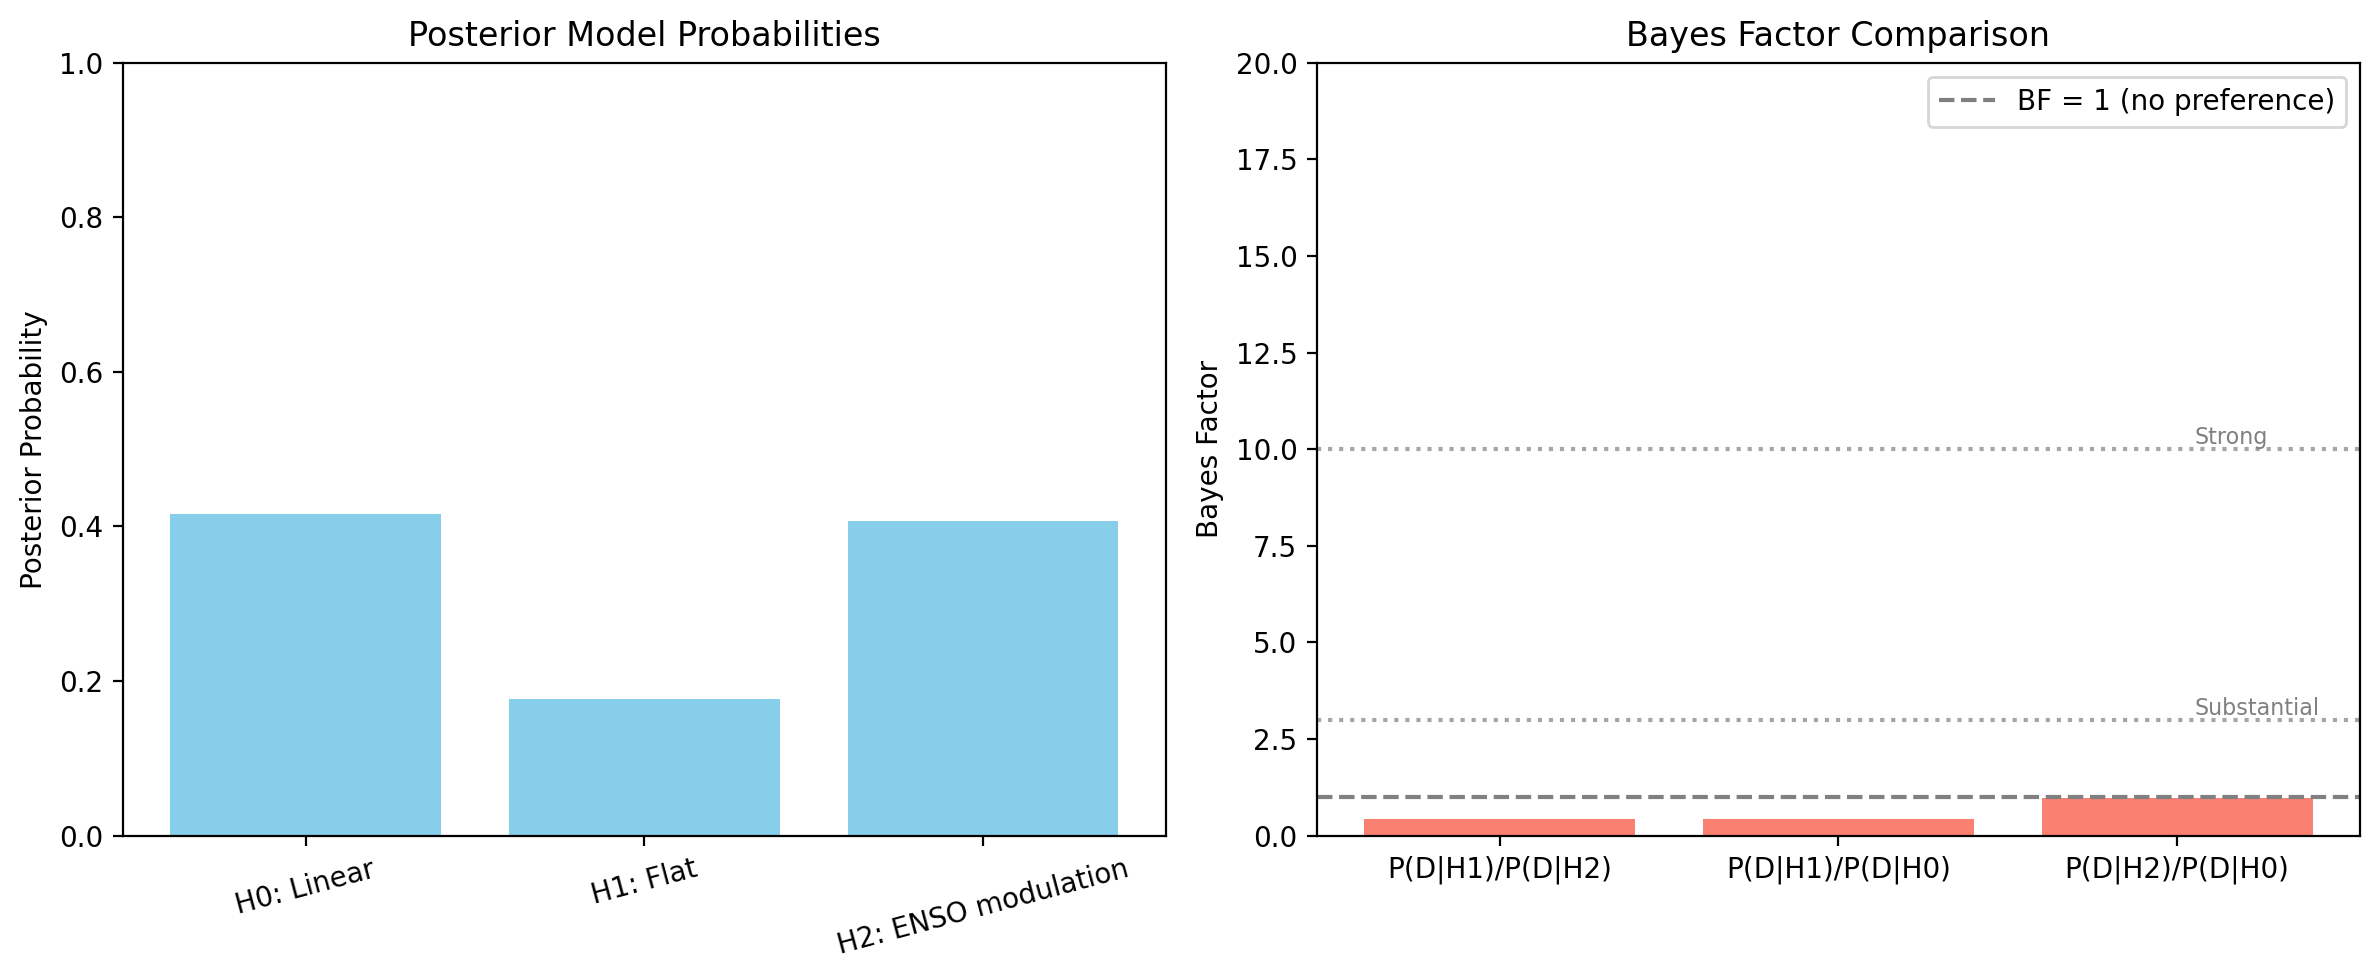

In [15]:
# --- Model labels ---
model_labels = {
    0: "H0: Linear",
    1: "H1: Flat",
    2: "H2: ENSO modulation"
}

# --- Prepare data for plotting ---
sorted_models = sorted(model_probs.items())  # ensure consistent order
labels = [model_labels[k] for k, _ in sorted_models]
probs = [v for _, v in sorted_models]

# === Plotting ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5),dpi=200)

# --- LEFT: Posterior Model Probabilities ---
axes[0].bar(labels, probs, color='skyblue')
axes[0].set_ylabel("Posterior Probability")
axes[0].set_title("Posterior Model Probabilities")
axes[0].tick_params(axis='x', rotation=15)
axes[0].set_ylim(0, 1)

# --- RIGHT: Bayes Factors ---
axes[1].bar(BFs.keys(), BFs.values(), color='salmon')
axes[1].axhline(1, color='gray', linestyle='--', label="BF = 1 (no preference)")
### Add Jeffereys scale
for thresh, label in [(3, "Substantial"), (10, "Strong")]:
    axes[1].axhline(thresh, color='gray', linestyle=':', alpha=0.7)
    axes[1].text(2.05, thresh, label, verticalalignment='bottom', color='gray', fontsize=8)
axes[1].set_ylabel("Bayes Factor")
axes[1].set_ylim(0,20)
axes[1].set_title("Bayes Factor Comparison")
axes[1].legend()

plt.tight_layout()
plt.show()


In [16]:
temps_h3_corr = temp_hadCRUT3_corrected.sel(t=slice('1979','2009')).groupby('t.year').mean('t').values.reshape([-1])
years = temp_hadCRUT3_corrected.sel(t=slice('1979','2009')).groupby('t.year').mean('t').year.values



model_space = [0, 1, 2]  # 0: linear, 1: flat, 2: trend + ENSO

# === Hyperparameters ===
n_iter = 10000
model_trace = []
param_trace = []

# === Initial model: start from H₀ ===
curr_model = 0  # 0 = no break, 1 = slowdown, 2 = flat
curr_params = [0.1, 0.2, 0.1]  # [a, b, sigma]

# === Helper: log-likelihoods ===
def log_likelihood(model, params):
    if model == 0:
        a, b, sigma = params
        mu = a + b * years

    elif model == 1:
        a1, b1, a2, sigma = params
        mu = np.where(years <= 1998, a1 + b1 * years, a2)

    elif model == 2:
        a, b, sigma = params  # gamma is fixed externally
        mu = a + b * years + gamma_fixed * oni_vals

    return np.sum(norm.logpdf(temps_h3_corr, mu, sigma))

def log_prior(model, params):
    return sum(norm.logpdf(p, 0, 1) for p in params)


# === Helper: model jump proposals ===
def propose_params(curr_model, curr_params, proposed_model):
    # --- Unpack current parameters safely ---
    if curr_model == 0:
        a, b, sigma = curr_params
    elif curr_model == 1:
        a1, b1, a2, sigma = curr_params
    elif curr_model == 2:
        a, b, sigma = curr_params

    # === Propose new parameters ===
    if proposed_model == 0:
        # Linear
        if curr_model == 1:
            a = a1
            b = b1
        elif curr_model == 2:
            a = a
            b = b
        return [a, b, sigma]

    elif proposed_model == 1:
        # Flat after 2000
        if curr_model == 0:
            a1 = a
            b1 = b
        elif curr_model == 2:
            a1 = a
            b1 = b
        a2 = a1 + np.random.normal(0, 0.05)
        return [a1, b1, a2, sigma]

    elif proposed_model == 2:
        # ENSO-fixed model
        if curr_model == 0:
            a = a
            b = b
        elif curr_model == 1:
            a = a1
            b = b1
        return [a, b, sigma]


# === Main RJMCMC loop ===
for i in range(n_iter):
    if np.random.rand() < 0.2:
        # Propose model jump
        proposed_model = np.random.choice([m for m in model_space if m != curr_model])
        prop_params = propose_params(curr_model, curr_params, proposed_model)
    else:
        # Within-model parameter update
        proposed_model = curr_model
        prop_params = [p + np.random.normal(0, 0.01) for p in curr_params]

    # Compute posterior log-probabilities
    log_post_curr = log_likelihood(curr_model, curr_params) + log_prior(curr_model, curr_params)
    log_post_prop = log_likelihood(proposed_model, prop_params) + log_prior(proposed_model, prop_params)

    # Metropolis-Hastings acceptance
    log_alpha = log_post_prop - log_post_curr
    if np.log(np.random.rand()) < log_alpha:
        curr_model = proposed_model
        curr_params = prop_params

    # Save traces
    model_trace.append(curr_model)
    param_trace.append(curr_params)

# === After sampling: model probabilities ===
import collections
counts = collections.Counter(model_trace)
total = len(model_trace)
model_probs_h3_corr = {k: v / total for k, v in counts.items()}
BF_2_1_h3_corr = model_probs_h3_corr.get(1, 1e-8) / model_probs_h3_corr.get(2, 1e-8)
BF_0_1_h3_corr = model_probs_h3_corr.get(1, 1e-8) / model_probs_h3_corr.get(0, 1e-8)
BF_0_2_h3_corr = model_probs_h3_corr.get(2, 1e-8) / model_probs_h3_corr.get(0, 1e-8)


BFs_h3_corr = {
    "P(D|H1)/P(D|H2)": BF_2_1_h3_corr,
    "P(D|H1)/P(D|H0)": BF_0_1_h3_corr,
    "P(D|H2)/P(D|H0)": BF_0_2_h3_corr
}

In [17]:
### HadCRUT5 
da_year = (
    temperature_data
    .sel(time=slice("1979","2009"))
    .groupby("time.year")
    .mean("time")
)
temp_hadCRUT5 = da_year.values.astype(float)
t_year = da_year.year.values.astype(float)
years = t_year



model_space = [0, 1, 2]  # 0: linear, 1: flat, 2: trend + ENSO

# === Hyperparameters ===
n_iter = 10000
model_trace = []
param_trace = []

# === Initial model: start from H₀ ===
curr_model = 0  # 0 = no break, 1 = slowdown, 2 = flat
curr_params = [0.1, 0.2, 0.1]  # [a, b, sigma]

# === Helper: log-likelihoods ===
def log_likelihood(model, params):
    if model == 0:
        a, b, sigma = params
        mu = a + b * years

    elif model == 1:
        a1, b1, a2, sigma = params
        mu = np.where(years <= 1998, a1 + b1 * years, a2)

    elif model == 2:
        a, b, sigma = params  # gamma is fixed externally
        mu = a + b * years + gamma_fixed * oni_vals

    return np.sum(norm.logpdf(temp_hadCRUT5, mu, sigma))

def log_prior(model, params):
    return sum(norm.logpdf(p, 0, 1) for p in params)


# === Helper: model jump proposals ===
def propose_params(curr_model, curr_params, proposed_model):
    # --- Unpack current parameters safely ---
    if curr_model == 0:
        a, b, sigma = curr_params
    elif curr_model == 1:
        a1, b1, a2, sigma = curr_params
    elif curr_model == 2:
        a, b, sigma = curr_params

    # === Propose new parameters ===
    if proposed_model == 0:
        # Linear
        if curr_model == 1:
            a = a1
            b = b1
        elif curr_model == 2:
            a = a
            b = b
        return [a, b, sigma]

    elif proposed_model == 1:
        # Flat after 2000
        if curr_model == 0:
            a1 = a
            b1 = b
        elif curr_model == 2:
            a1 = a
            b1 = b
        a2 = a1 + np.random.normal(0, 0.05)
        return [a1, b1, a2, sigma]

    elif proposed_model == 2:
        # ENSO-fixed model
        if curr_model == 0:
            a = a
            b = b
        elif curr_model == 1:
            a = a1
            b = b1
        return [a, b, sigma]


# === Main RJMCMC loop ===
for i in range(n_iter):
    if np.random.rand() < 0.2:
        # Propose model jump
        proposed_model = np.random.choice([m for m in model_space if m != curr_model])
        prop_params = propose_params(curr_model, curr_params, proposed_model)
    else:
        # Within-model parameter update
        proposed_model = curr_model
        prop_params = [p + np.random.normal(0, 0.01) for p in curr_params]

    # Compute posterior log-probabilities
    log_post_curr = log_likelihood(curr_model, curr_params) + log_prior(curr_model, curr_params)
    log_post_prop = log_likelihood(proposed_model, prop_params) + log_prior(proposed_model, prop_params)

    # Metropolis-Hastings acceptance
    log_alpha = log_post_prop - log_post_curr
    if np.log(np.random.rand()) < log_alpha:
        curr_model = proposed_model
        curr_params = prop_params

    # Save traces
    model_trace.append(curr_model)
    param_trace.append(curr_params)

# === After sampling: model probabilities ===
import collections
counts = collections.Counter(model_trace)
total = len(model_trace)
model_probs_h5 = {k: v / total for k, v in counts.items()}
BF_2_1_h5 = model_probs_h5.get(1, 1e-8) / model_probs_h5.get(2, 1e-8)
BF_0_1_h5 = model_probs_h5.get(1, 1e-8) / model_probs_h5.get(0, 1e-8)
BF_0_2_h5 = model_probs_h5.get(2, 1e-8) / model_probs_h5.get(0, 1e-8)

print(f"Model probabilities: {model_probs_h5}")
print(f"Bayes Factor (H1 vs H2): {BF_2_1_h5:.2f}")
print(f"Bayes Factor (H1 vs H0): {BF_0_2_h5:.2f}")
print(f"Bayes Factor (H2 vs H0): {BF_0_1_h5:.2f}")

BFs_h5 = {
    "P(D|H1)/P(D|H2)": BF_2_1_h5,
    "P(D|H1)/P(D|H0)": BF_0_1_h5,
    "P(D|H2)/P(D|H0)": BF_0_2_h5
}

Model probabilities: {np.int64(1): 0.0395, np.int64(2): 0.4492, np.int64(0): 0.5113}
Bayes Factor (H1 vs H2): 0.09
Bayes Factor (H1 vs H0): 0.88
Bayes Factor (H2 vs H0): 0.08


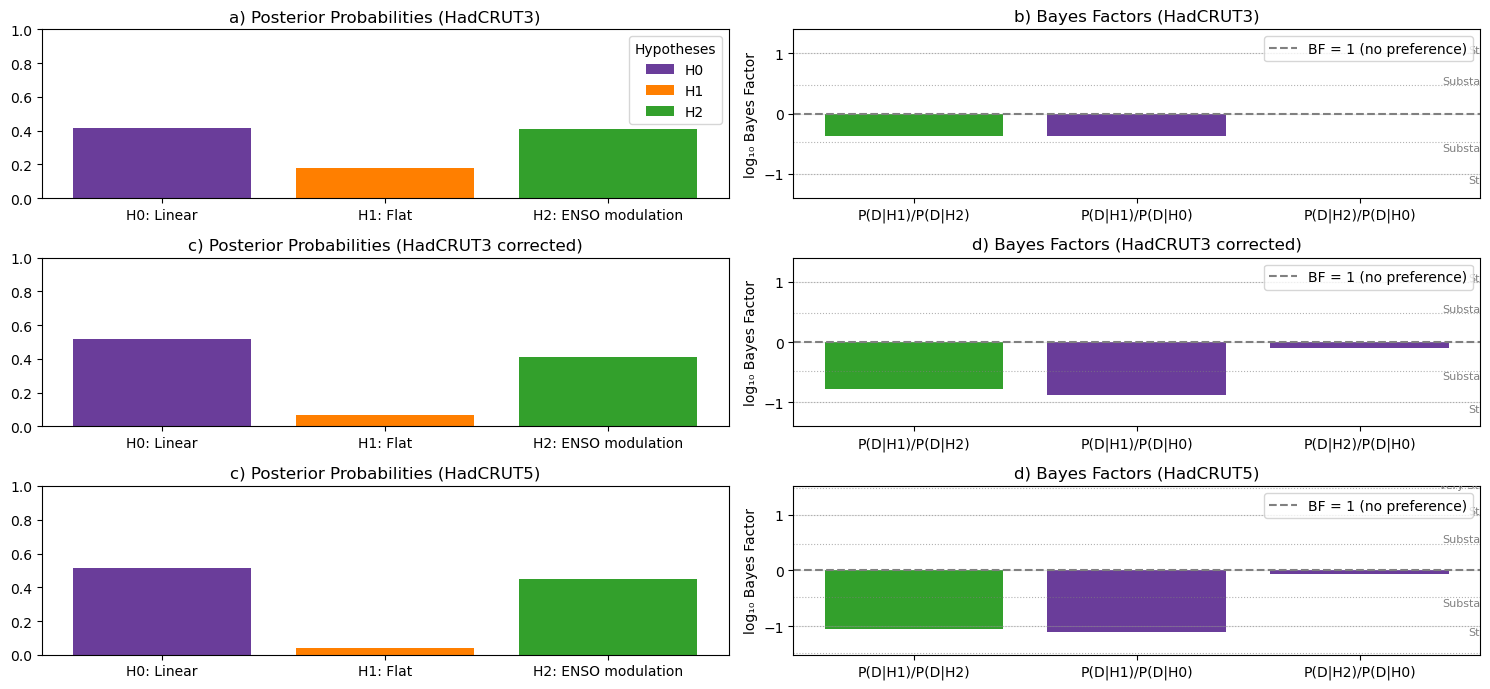

In [18]:
# === Colors for hypotheses ===
H_COL = {"H0": "#6a3d9a",  # purple
         "H1": "#ff7f00",  # orange
         "H2": "#33a02c"}  # green

# --- Helpers ---
def parse_hypotheses(label):
    """Extract ('Hi','Hj') from 'P(D|Hi)/P(D|Hj)'. Robust to spacing."""
    hs = re.findall(r"H\d+", label)
    if len(hs) < 2:
        raise ValueError(f"Could not parse hypothesis pair from label: {label}")
    return hs[0], hs[1]

def get_bf_colors(bf_dict):
    """Color by winning hypothesis: BF>1 → numerator; else denominator."""
    colors = []
    for lbl, val in bf_dict.items():
        num, den = parse_hypotheses(lbl)
        colors.append(H_COL[num] if val > 1 else H_COL[den])
    return colors

def prob_colors_from_keys(keys):
    """Map model keys (0/1/2 or 'H0' etc.) to H_COL order."""
    out = []
    for k in sorted(keys):
        s = str(k)
        h = s if s.startswith("H") else f"H{int(s)}"
        out.append(H_COL[h])
    return out

def draw_log10_bf_panel(ax, bf_dict, title):
    """
    Draw a Bayes-factor panel with log10(BF) bars, Jeffreys thresholds both directions,
    and labels clipped inside the axis.
    """
    keys = list(bf_dict.keys())
    vals = np.array(list(bf_dict.values()), dtype=float)
    log_vals = np.log10(vals)

    # Bars colored by winner on original (linear) BF values
    ax.bar(keys, log_vals, color=get_bf_colors(bf_dict))
    ax.axhline(0, color='gray', linestyle='--', label='BF = 1 (no preference)')

    # Jeffreys thresholds (±)
    pos = [np.log10(3), np.log10(10), np.log10(30), np.log10(100)]
    neg = [-p for p in pos]
    thresholds = [(t, lab) for t, lab in zip(pos, ["Substantial","Strong","Very Strong","Decisive"])]
    thresholds += [(t, lab) for t, lab in zip(neg, ["Substantial","Strong","Very Strong","Decisive"])]

    # Nice symmetric y-lims around 0 (pad by 0.2, cap at ±3 to avoid super tall figure)
    max_abs = max(1.0, float(np.nanmax(np.abs(log_vals))) if log_vals.size else 1.0)
    ylim = min(max_abs + 0.4, 3.0)
    ax.set_ylim(-ylim, ylim)

    # Draw lines and labels inside the panel at the right edge
    x_text = len(keys) - 0.35 if len(keys) else 0.6
    for t, lab in thresholds:
        # Skip drawing thresholds outside current ylim
        if t < ax.get_ylim()[0] or t > ax.get_ylim()[1]:
            continue
        ax.axhline(t, color='gray', linestyle=':', alpha=0.6, lw=0.8)
        ax.text(x_text, t * (0.98 if t > 0 else 1.02),
                lab,
                va='bottom' if t > 0 else 'top',
                ha='right', fontsize=8, color='gray', clip_on=True)

    # Y ticks at integer logs within the limits (e.g., -2,-1,0,1,2)
    yticks = [i for i in range(-3, 4) if -ylim <= i <= ylim]
    ax.set_yticks(yticks)
    ax.set_ylabel("log₁₀ Bayes Factor")
    ax.set_title(title)
    ax.grid(axis='y', alpha=0.3)
    ax.legend(loc='upper right')

# === Figure ===
fig, axes = plt.subplots(3, 2, figsize=(15, 7))  # slightly shorter

# --- (a) Posterior Probabilities (HadCRUT3) ---
labels = [model_labels[k] for k in sorted(model_probs)]
probs  = [model_probs.get(k, 0) for k in sorted(model_probs)]
axes[0, 0].bar(labels, probs, color=prob_colors_from_keys(model_probs.keys()))
axes[0, 0].set_title("a) Posterior Probabilities (HadCRUT3)")
axes[0, 0].set_ylim(0, 1)

# --- (b) Bayes Factors (HadCRUT3) — log10(BF) style ---
# You said you already have:

draw_log10_bf_panel(axes[0, 1], BFs, "b) Bayes Factors (HadCRUT3)")

# --- (c) Posterior Probabilities (HadCRUT5) ---
labels_h3_corr = [model_labels[k] for k in sorted(model_probs_h3_corr)]
probs_h3_corr  = [model_probs_h3_corr.get(k, 0) for k in sorted(model_probs_h3_corr)]
axes[1, 0].bar(labels_h3_corr, probs_h3_corr, color=prob_colors_from_keys(model_probs_h3_corr.keys()))
axes[1, 0].set_title("c) Posterior Probabilities (HadCRUT3 corrected)")
axes[1, 0].set_ylim(0, 1)
# --- (d) Bayes Factors (HadCRUT5) — log10(BF) style ---


draw_log10_bf_panel(axes[1, 1], BFs_h3_corr, "d) Bayes Factors (HadCRUT3 corrected)")

# --- (e) Posterior Probabilities (HadCRUT5) ---
labels_h5 = [model_labels[k] for k in sorted(model_probs_h5)]
probs_h5  = [model_probs_h5.get(k, 0) for k in sorted(model_probs_h5)]
axes[2, 0].bar(labels_h5, probs_h5, color=prob_colors_from_keys(model_probs_h5.keys()))
axes[2, 0].set_title("c) Posterior Probabilities (HadCRUT5)")
axes[2, 0].set_ylim(0, 1)
# --- (f) Bayes Factors (HadCRUT5) — log10(BF) style ---


draw_log10_bf_panel(axes[2, 1], BFs_h5, "d) Bayes Factors (HadCRUT5)")



# Legend for hypothesis colors (put once)
legend_patches = [Patch(facecolor=c, label=h) for h, c in H_COL.items()]
axes[0, 0].legend(handles=legend_patches, title="Hypotheses", loc='upper right')

plt.tight_layout()
plt.show()


/tmp/ipykernel_3059501/1373185737.py:130: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.10, 1, 1])  # leave space at bottom (7% height)


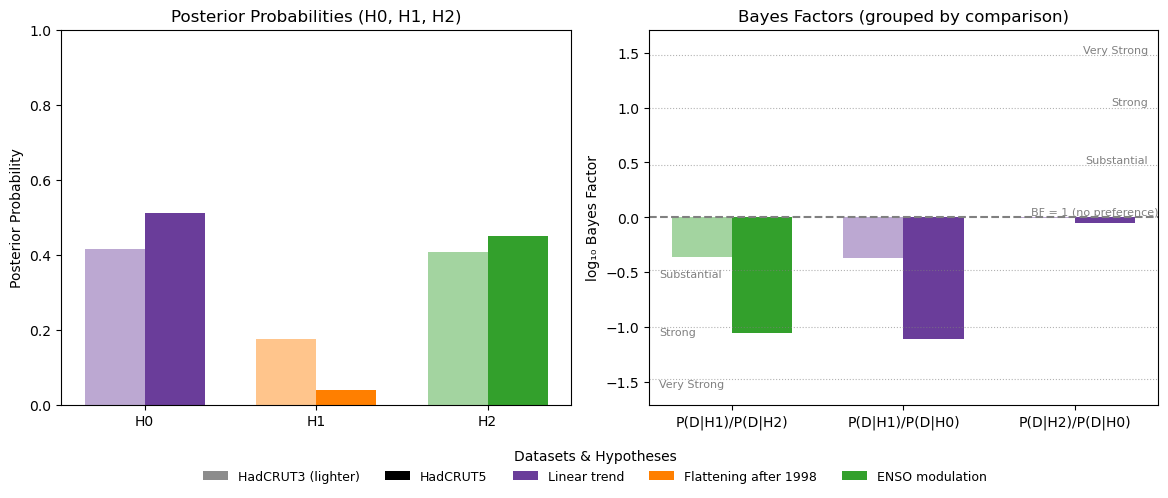

In [19]:
# === Colors for hypotheses ===
H_COL = {"H0": "#6a3d9a",  # purple
         "H1": "#ff7f00",  # orange
         "H2": "#33a02c"}  # green

def lighten(hex_color, amount=0.5):
    """Blend a color with white by 'amount' (0=no change, 1=white)."""
    r, g, b = to_rgb(hex_color)
    r = r + (1 - r) * amount
    g = g + (1 - g) * amount
    b = b + (1 - b) * amount
    return (r, g, b)

def parse_hypotheses(label):
    """Extract ('Hi','Hj') from 'P(D|Hi)/P(D|Hj)'."""
    hs = re.findall(r"H\d+", label)
    if len(hs) < 2:
        raise ValueError(f"Could not parse hypothesis pair from label: {label}")
    return hs[0], hs[1]

def bf_winner_color(label, value, light=False):
    """Color by winning hypothesis (numerator if BF>1 else denominator)."""
    num, den = parse_hypotheses(label)
    base = H_COL[num] if value > 1 else H_COL[den]
    return lighten(base, 0.55) if light else base

def key_to_H(k):
    """Normalize model key (0/1/2 or '0'/'1'/'2' or 'H0') -> 'H#'."""
    s = str(k)
    return s if s.startswith("H") else f"H{int(s)}"

# ---- Build consistent hypothesis order and labels
H_ORDER = ["H0", "H1", "H2"]
labels_post = [h for h in H_ORDER]  # show H0, H1, H2

# ---- Data you already have:
# model_probs, model_probs_h5, model_labels
# BFs, BFs_h5 (with keys "P(D|H2)/P(D|H1)", "P(D|H1)/P(D|H0)", "P(D|H2)/P(D|H0)")

# Posterior arrays in H0,H1,H2 order
probs_h3 = [model_probs.get(int(h[1]), model_probs.get(h[1], 0)) if isinstance(next(iter(model_probs)), int)
            else model_probs.get(h[1], 0) for h in H_ORDER]
# if model_probs keys are like 0/1/2 or '0'/'1'/'2' or 'H0', handle generically:
def get_prob(dct, h):
    # try int, string int, 'H#'
    i = int(h[1])
    return dct.get(i, dct.get(str(i), dct.get(h, 0)))
probs_h3 = [get_prob(model_probs, h) for h in H_ORDER]
probs_h5 = [get_prob(model_probs_h5, h) for h in H_ORDER]

# Colors for posterior bars
cols_h3_post = [lighten(H_COL[h], 0.55) for h in H_ORDER]  # lighter
cols_h5_post = [H_COL[h] for h in H_ORDER]                 # full

# Order for BF labels (groups on x-axis)
BF_ORDER = ["P(D|H1)/P(D|H2)", "P(D|H1)/P(D|H0)", "P(D|H2)/P(D|H0)"]
bf_vals_h3 = [BFs[k] for k in BF_ORDER]
bf_vals_h5 = [BFs_h5[k] for k in BF_ORDER]
log_bf_h3  = np.log10(bf_vals_h3)
log_bf_h5  = np.log10(bf_vals_h5)
cols_h3_bf = [bf_winner_color(k, v, light=True)  for k, v in zip(BF_ORDER, bf_vals_h3)]
cols_h5_bf = [bf_winner_color(k, v, light=False) for k, v in zip(BF_ORDER, bf_vals_h5)]

# === Figure with two subplots ===
fig, (axL, axR) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# --- LEFT: Posterior Probabilities (grouped bars) ---
x = np.arange(len(H_ORDER))
w = 0.35
axL.bar(x - w/2, probs_h3, width=w, color=cols_h3_post, label="HadCRUT3")
axL.bar(x + w/2, probs_h5, width=w, color=cols_h5_post, label="HadCRUT5")
axL.set_xticks(x, labels_post)
axL.set_ylim(0, 1)
axL.set_ylabel("Posterior Probability")
axL.set_title("Posterior Probabilities (H0, H1, H2)")

# --- RIGHT: Bayes Factors (grouped bars, log10) ---
x_bf = np.arange(len(BF_ORDER))
axR.bar(x_bf - w/2, log_bf_h3, width=w, color=cols_h3_bf, label="HadCRUT3")
axR.bar(x_bf + w/2, log_bf_h5, width=w, color=cols_h5_bf, label="HadCRUT5")

# BF=1 line at 0 with left-corner label
axR.axhline(0, color='gray', linestyle='--')
axR.text(0.75, 0, "BF = 1 (no preference)",
         transform=axR.get_yaxis_transform(), ha='left', va='bottom', fontsize=8, color='gray')

# Jeffreys thresholds (inside): positives on right, negatives on left
pos = [np.log10(3), np.log10(10), np.log10(30), np.log10(100)]
labels_j = ["Substantial", "Strong", "Very Strong", "Decisive"]
neg = [-p for p in pos]

# Symmetric tight y-lims across BOTH datasets
max_abs = max(1.0, np.nanmax(np.abs(np.r_[log_bf_h3, log_bf_h5])))
ylim = min(max_abs + 0.6, 3.0)
axR.set_ylim(-ylim, ylim)

# Draw lines + labels inside
for t, lab in zip(pos, labels_j):
    if t <= ylim:
        axR.axhline(t, color='gray', linestyle=':', alpha=0.6, lw=0.8)
        axR.text(0.98, t, lab, transform=axR.get_yaxis_transform(),
                 ha='right', va='bottom', fontsize=8, color='gray', clip_on=True)
for t, lab in zip(neg, labels_j):
    if t >= -ylim:
        axR.axhline(t, color='gray', linestyle=':', alpha=0.6, lw=0.8)
        axR.text(0.02, t, lab, transform=axR.get_yaxis_transform(),
                 ha='left', va='top', fontsize=8, color='gray', clip_on=True)

axR.set_xticks(x_bf, BF_ORDER)
axR.set_ylabel("log₁₀ Bayes Factor")
axR.set_title("Bayes Factors (grouped by comparison)")

# --- Legend ONLY once (below) ---
legend_patches = [Patch(facecolor=H_COL[h], label=h) for h in H_ORDER]
legend_sets = [Patch(facecolor=lighten("#000000", 1.0), label="")]  # dummy spacer if desired

# Dataset legend (HadCRUT3 lighter, HadCRUT5 full)
leg_handles = [
    Patch(facecolor=lighten(H_COL["H0"], 0.55), label="HadCRUT3 (lighter)"),
    Patch(facecolor=H_COL["H0"],            label="HadCRUT5"),
]

# Adjust layout before adding legend
plt.tight_layout(rect=[0, 0.10, 1, 1])  # leave space at bottom (7% height)

# Legend entries
leg_handles = [
    Patch(facecolor=lighten('k', 0.55), label="HadCRUT3 (lighter)"),
    Patch(facecolor='k', label="HadCRUT5"),
    Patch(facecolor=H_COL["H0"], label="Linear trend", edgecolor='none'),
    Patch(facecolor=H_COL["H1"], label="Flattening after 1998", edgecolor='none'),
    Patch(facecolor=H_COL["H2"], label="ENSO modulation", edgecolor='none'),
]

# Centered legend at bottom
fig.legend(
    handles=leg_handles,
    loc="lower center",
    ncol=5,
    frameon=False,
    bbox_to_anchor=(0.5, 0.0),  # further down below figure
    fontsize=9,
    title="Datasets & Hypotheses"
)


plt.show()


/tmp/ipykernel_3059501/2948532448.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.12, 1, 1])  # leave space at bottom


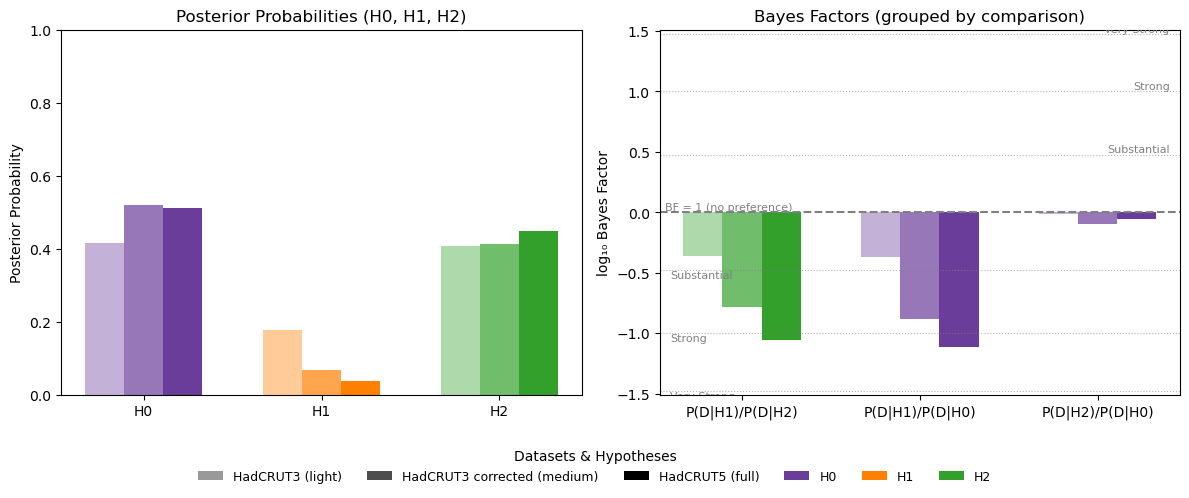

In [20]:
# === Colors for hypotheses ===
H_COL = {"H0": "#6a3d9a",  # purple
         "H1": "#ff7f00",  # orange
         "H2": "#33a02c"}  # green

def lighten(hex_color, amount=0.5):
    """Blend a color with white by 'amount' (0=no change, 1=white)."""
    r, g, b = to_rgb(hex_color)
    r = r + (1 - r) * amount
    g = g + (1 - g) * amount
    b = b + (1 - b) * amount
    return (r, g, b)

def parse_hypotheses(label):
    """Extract ('Hi','Hj') from 'P(D|Hi)/P(D|Hj)'."""
    hs = re.findall(r"H\d+", label)
    if len(hs) < 2:
        raise ValueError(f"Could not parse hypothesis pair from label: {label}")
    return hs[0], hs[1]

def bf_winner_color(label, value, variant="full"):
    """
    Color by winning hypothesis (numerator if BF>1 else denominator).
    variant: 'light' (HadCRUT3), 'mid' (HadCRUT3 corrected), 'full' (HadCRUT5)
    """
    num, den = parse_hypotheses(label)
    base = H_COL[num] if value > 1 else H_COL[den]
    if variant == "light":
        return lighten(base, 0.60)
    if variant == "mid":
        return lighten(base, 0.30)
    return base  # 'full'

def get_prob(dct, h_label):
    """Fetch probability for 'H#' from dict with keys like 0/1/2 or '0'/'1'/'2'/'H#'."""
    i = int(h_label[1])
    return dct.get(i, dct.get(str(i), dct.get(h_label, 0)))

# ---- Build consistent hypothesis order and labels
H_ORDER = ["H0", "H1", "H2"]
labels_post = H_ORDER[:]

# ---- Posterior arrays (H0,H1,H2 order)
probs_h3      = [get_prob(model_probs,          h) for h in H_ORDER]
probs_h3_corr = [get_prob(model_probs_h3_corr,  h) for h in H_ORDER]
probs_h5      = [get_prob(model_probs_h5,       h) for h in H_ORDER]

# Colors for posterior bars
cols_h3_post      = [lighten(H_COL[h], 0.60) for h in H_ORDER]  # light
cols_h3_corr_post = [lighten(H_COL[h], 0.30) for h in H_ORDER]  # medium
cols_h5_post      = [H_COL[h]           for h in H_ORDER]       # full

# ---- Bayes factors
# Use the order from BFs and require the others to have same keys
BF_ORDER = list(BFs.keys())
# Optional sanity check (keeps only common keys and preserves order)
BF_ORDER = [k for k in BF_ORDER if k in BFs_h3_corr and k in BFs_h5]

bf_vals_h3      = [BFs[k]           for k in BF_ORDER]
bf_vals_h3_corr = [BFs_h3_corr[k]   for k in BF_ORDER]
bf_vals_h5      = [BFs_h5[k]        for k in BF_ORDER]

log_bf_h3      = np.log10(bf_vals_h3)
log_bf_h3_corr = np.log10(bf_vals_h3_corr)
log_bf_h5      = np.log10(bf_vals_h5)

cols_h3_bf      = [bf_winner_color(k, v, "light") for k, v in zip(BF_ORDER, bf_vals_h3)]
cols_h3_corr_bf = [bf_winner_color(k, v, "mid")   for k, v in zip(BF_ORDER, bf_vals_h3_corr)]
cols_h5_bf      = [bf_winner_color(k, v, "full")  for k, v in zip(BF_ORDER, bf_vals_h5)]

# === Figure with two subplots ===
fig, (axL, axR) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# --- LEFT: Posterior Probabilities (grouped bars with 3 datasets) ---
x = np.arange(len(H_ORDER))
w = 0.22  # narrower to fit 3 bars per group
axL.bar(x - w,        probs_h3,      width=w, color=cols_h3_post,      label="HadCRUT3 (light)")
axL.bar(x,            probs_h3_corr, width=w, color=cols_h3_corr_post, label="HadCRUT3 corrected (medium)")
axL.bar(x + w,        probs_h5,      width=w, color=cols_h5_post,      label="HadCRUT5 (full)")
axL.set_xticks(x, labels_post)
axL.set_ylim(0, 1)
axL.set_ylabel("Posterior Probability")
axL.set_title("Posterior Probabilities (H0, H1, H2)")

# --- RIGHT: Bayes Factors (grouped bars, log10) with 3 datasets ---
x_bf = np.arange(len(BF_ORDER))
axR.bar(x_bf - w, log_bf_h3,      width=w, color=cols_h3_bf,      label="HadCRUT3 (light)")
axR.bar(x_bf,      log_bf_h3_corr, width=w, color=cols_h3_corr_bf, label="HadCRUT3 corrected (medium)")
axR.bar(x_bf + w,  log_bf_h5,      width=w, color=cols_h5_bf,      label="HadCRUT5 (full)")

# BF=1 line at 0 with left-corner label
axR.axhline(0, color='gray', linestyle='--')
axR.text(0.01, 0, "BF = 1 (no preference)",
         transform=axR.get_yaxis_transform(), ha='left', va='bottom', fontsize=8, color='gray')

# Jeffreys thresholds (inside): positives on right, negatives on left
pos = [np.log10(3), np.log10(10), np.log10(30), np.log10(100)]
labels_j = ["Substantial", "Strong", "Very Strong", "Decisive"]
neg = [-p for p in pos]

# Symmetric tight y-lims across all three datasets
max_abs = max(1.0, np.nanmax(np.abs(np.r_[log_bf_h3, log_bf_h3_corr, log_bf_h5])))
ylim = min(max_abs + 0.4, 3.0)
axR.set_ylim(-ylim, ylim)

for t, lab in zip(pos, labels_j):
    if t <= ylim:
        axR.axhline(t, color='gray', linestyle=':', alpha=0.6, lw=0.8)
        axR.text(0.98, t, lab, transform=axR.get_yaxis_transform(),
                 ha='right', va='bottom', fontsize=8, color='gray', clip_on=True)
for t, lab in zip(neg, labels_j):
    if t >= -ylim:
        axR.axhline(t, color='gray', linestyle=':', alpha=0.6, lw=0.8)
        axR.text(0.02, t, lab, transform=axR.get_yaxis_transform(),
                 ha='left', va='top', fontsize=8, color='gray', clip_on=True)

axR.set_xticks(x_bf, BF_ORDER)
axR.set_ylabel("log₁₀ Bayes Factor")
axR.set_title("Bayes Factors (grouped by comparison)")

# --- Legend ONLY once (lower center) ---
plt.tight_layout(rect=[0, 0.12, 1, 1])  # leave space at bottom
fig.legend(
    handles=[
        Patch(facecolor=lighten("#000000", 0.60), label="HadCRUT3 (light)"),
        Patch(facecolor=lighten("#000000", 0.30), label="HadCRUT3 corrected (medium)"),
        Patch(facecolor="#000000",                label="HadCRUT5 (full)"),
        Patch(facecolor=H_COL["H0"], label="H0", edgecolor='none'),
        Patch(facecolor=H_COL["H1"], label="H1", edgecolor='none'),
        Patch(facecolor=H_COL["H2"], label="H2", edgecolor='none'),
    ],
    loc="lower center", ncol=6, frameon=False, bbox_to_anchor=(0.5, 0.00), fontsize=9,
    title="Datasets & Hypotheses"
)

plt.show()


/tmp/ipykernel_3059501/3424556610.py:200: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.07, 1, 1])  # leave space at bottom


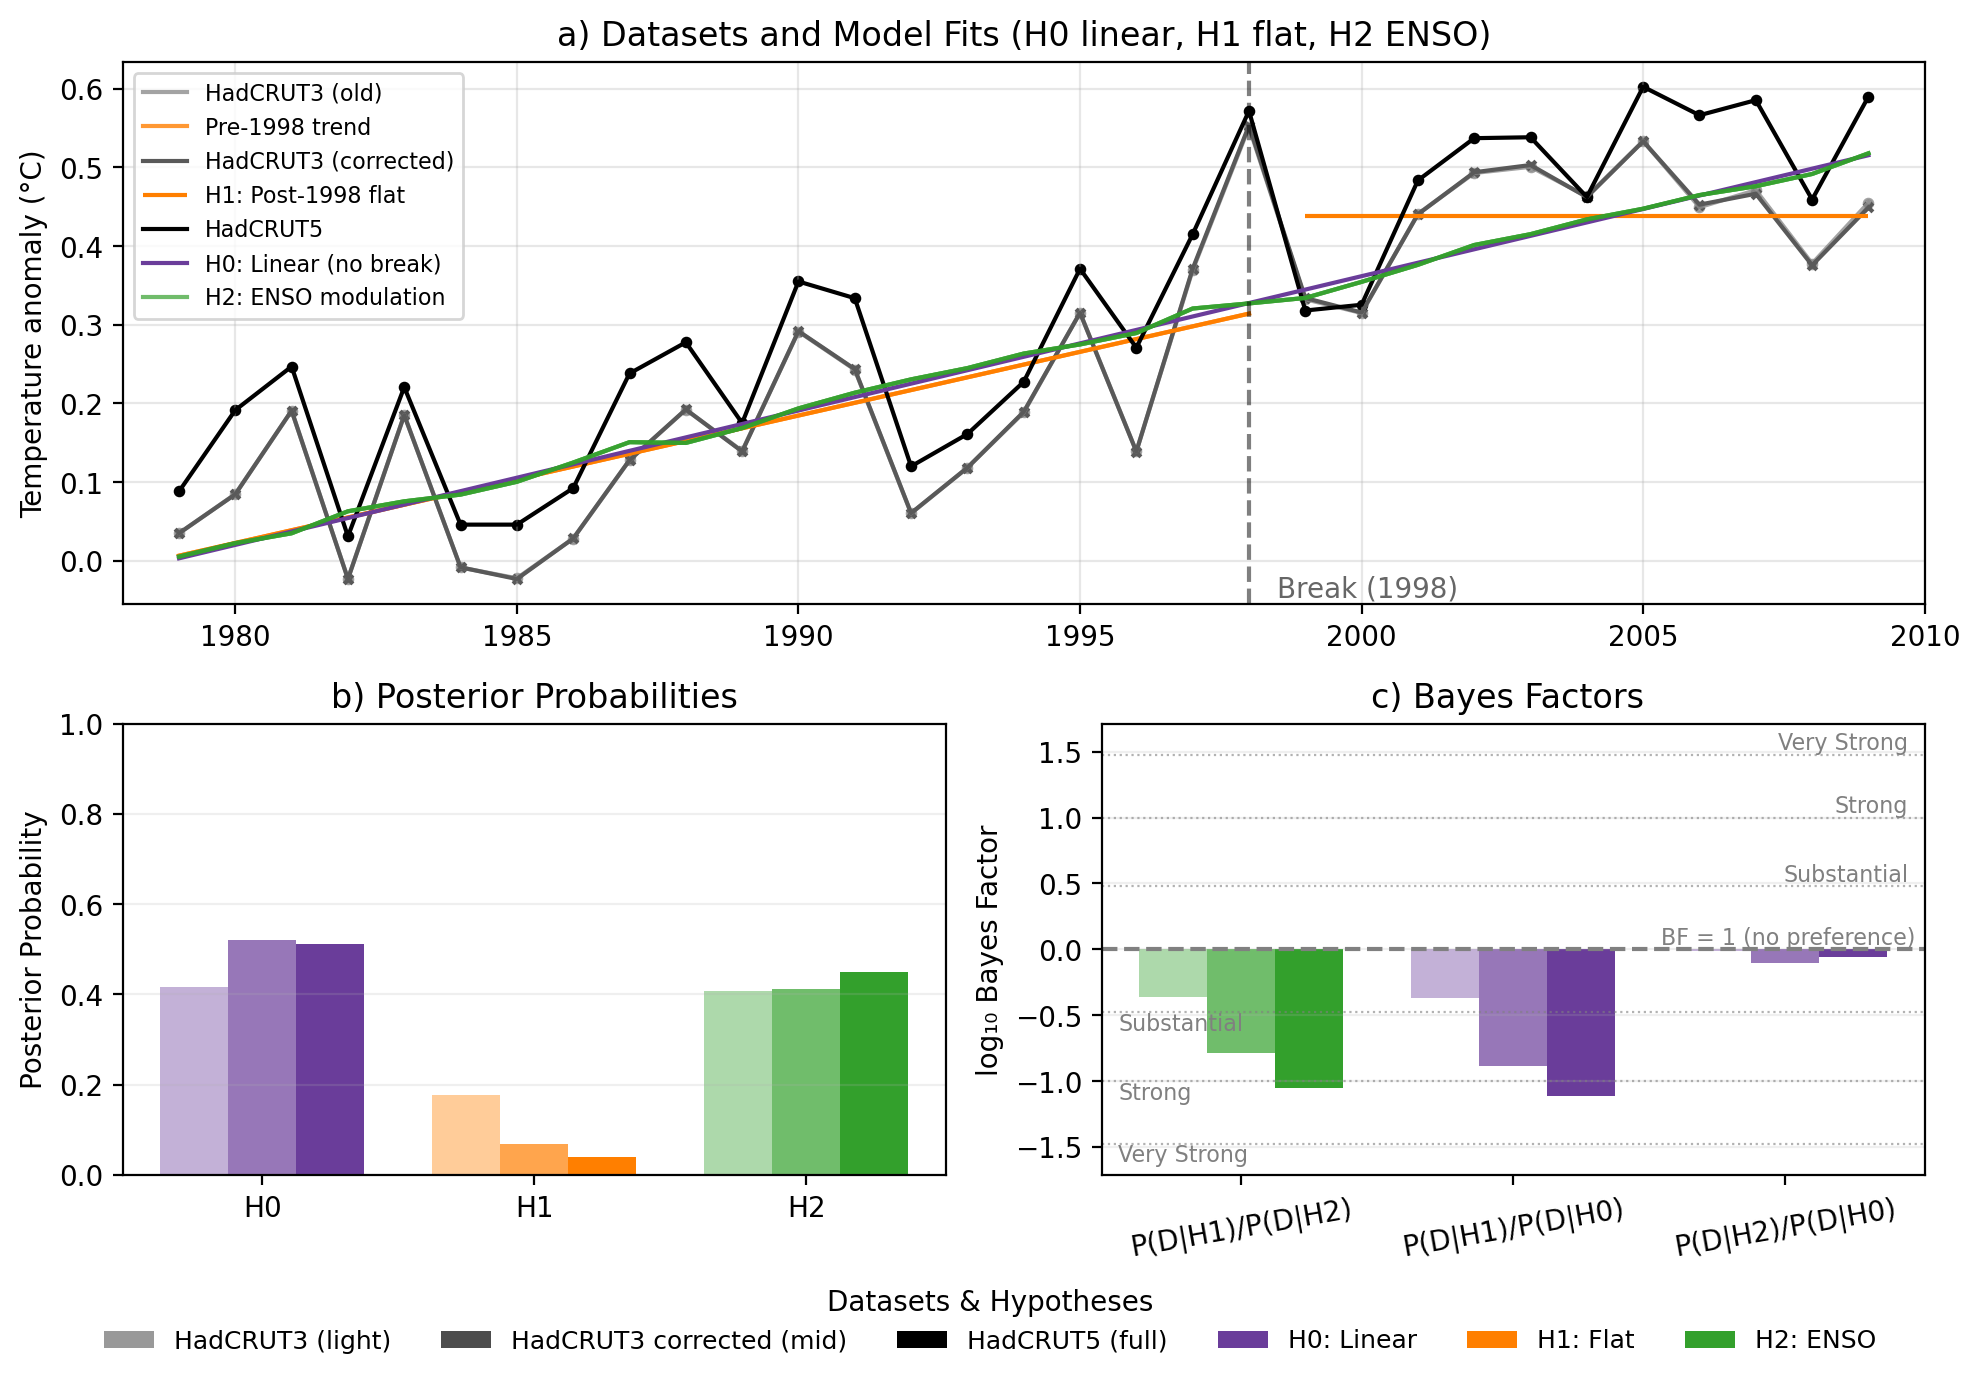

In [21]:
# === Colors for hypotheses ===
H_COL = {"H0": "#6a3d9a",  # purple  (Linear trend)
         "H1": "#ff7f00",  # orange  (Flattening after 1998)
         "H2": "#33a02c"}  # green   (ENSO modulation)

# Dataset base greys / black for top panel
COL_H3_OLD  = (0.55, 0.55, 0.55)   # grey
COL_H3_CORR = (0.35, 0.35, 0.35)   # darker grey
COL_H5      = (0.00, 0.00, 0.00)   # black

def lighten(hex_color, amount=0.5):
    r, g, b = to_rgb(hex_color)
    r = r + (1 - r) * amount
    g = g + (1 - g) * amount
    b = b + (1 - b) * amount
    return (r, g, b)

def parse_hypotheses(label):
    """Extract ('Hi','Hj') from 'P(D|Hi)/P(D|Hj)'."""
    hs = re.findall(r"H\d+", label)
    if len(hs) < 2:
        raise ValueError(f"Could not parse hypothesis pair from label: {label}")
    return hs[0], hs[1]

def bf_winner_color(label, value, variant="full"):
    """
    Color by winning hypothesis (numerator if BF>1 else denominator).
    variant: 'light' (H3 old), 'mid' (H3 corrected), 'full' (H5)
    """
    num, den = parse_hypotheses(label)
    base = H_COL[num] if value > 1 else H_COL[den]
    if variant == "light":
        return lighten(base, 0.60)
    if variant == "mid":
        return lighten(base, 0.30)
    return base

def get_prob(dct, h_label):
    """Fetch probability for 'H#' from dict with keys like 0/1/2 or '0'/'1'/'2'/'H#'."""
    i = int(h_label[1])
    return dct.get(i, dct.get(str(i), dct.get(h_label, 0)))

# -----------------------------
# Data to arrays for grouped bars
# -----------------------------
H_ORDER = ["H0", "H1", "H2"]
probs_h3      = [get_prob(model_probs,          h) for h in H_ORDER]
probs_h3_corr = [get_prob(model_probs_h3_corr,  h) for h in H_ORDER]
probs_h5      = [get_prob(model_probs_h5,       h) for h in H_ORDER]

cols_h3_post      = [lighten(H_COL[h], 0.60) for h in H_ORDER]  # light = HadCRUT3 old
cols_h3_corr_post = [lighten(H_COL[h], 0.30) for h in H_ORDER]  # mid   = HadCRUT3 corrected
cols_h5_post      = [H_COL[h]           for h in H_ORDER]       # full  = HadCRUT5

# Bayes factors — use key order from BFs, keep only common keys
BF_ORDER = [k for k in list(BFs.keys()) if k in BFs_h3_corr and k in BFs_h5]
bf_vals_h3      = [BFs[k]         for k in BF_ORDER]
bf_vals_h3_corr = [BFs_h3_corr[k] for k in BF_ORDER]
bf_vals_h5      = [BFs_h5[k]      for k in BF_ORDER]

log_bf_h3      = np.log10(bf_vals_h3)
log_bf_h3_corr = np.log10(bf_vals_h3_corr)
log_bf_h5      = np.log10(bf_vals_h5)

cols_h3_bf      = [bf_winner_color(k, v, "light") for k, v in zip(BF_ORDER, bf_vals_h3)]
cols_h3_corr_bf = [bf_winner_color(k, v, "mid")   for k, v in zip(BF_ORDER, bf_vals_h3_corr)]
cols_h5_bf      = [bf_winner_color(k, v, "full")  for k, v in zip(BF_ORDER, bf_vals_h5)]

# -----------------------------
# Figure layout: Top spans both columns; bottom has 2 panels
# -----------------------------
fig = plt.figure(figsize=(10, 7), constrained_layout=True,dpi=200)
gs = GridSpec(2, 2, figure=fig, height_ratios=[1.2, 1.0])
ax_top = fig.add_subplot(gs[0, :])     # top spans both
axL    = fig.add_subplot(gs[1, 0])     # bottom-left (posteriors)
axR    = fig.add_subplot(gs[1, 1])     # bottom-right (BFs)

# ============================
# TOP: Datasets & Model Fits
# ============================
# --- HadCRUT3 (old) ---
ax_top.plot(years, temp, color=COL_H3_OLD, label='HadCRUT3 (old)', alpha=0.8)
ax_top.scatter(years, temp, color=COL_H3_OLD, s=10, alpha=0.8)
ax_top.plot(years[:20], np.column_stack([np.ones(len(years[:20])), years[:20]]) @ beta0,
            color=H_COL["H1"], alpha=0.8, label='Pre-1998 trend')         # H1 color (orange) for break model parts


# --- HadCRUT3 (corrected) ---
ax_top.plot(years, temp_corr, color=COL_H3_CORR, label='HadCRUT3 (corrected)')
ax_top.scatter(years, temp_corr, color=COL_H3_CORR, s=10, marker='x')
ax_top.plot(years[:20], np.column_stack([np.ones(len(years[:20])), years[:20]]) @ beta0_corr,
            color=H_COL["H1"])
### Add a flat line for the perio 1999-2009
ax_top.hlines(y=np.mean(temp_corr[years > 1998]),
                xmin=1999, xmax=2009,
                color=H_COL["H1"],
                linestyle='-',
                label='H1: Post-1998 flat')


# --- HadCRUT5 ---
ax_top.plot(t_year,  temp_hadCRUT5, color=COL_H5, label='HadCRUT5')
ax_top.scatter(t_year, temp_hadCRUT5, color=COL_H5, s=10)


# --- Whole-period linear fit (H0) for the H3 old series (as representative) ---
X_full = np.column_stack([np.ones(len(years)), years])
beta_full = ols(X_full, temp)
ax_top.plot(years, X_full @ beta_full, color=H_COL["H0"], linestyle='-', label='H0: Linear (no break)')

# --- Optional ENSO fit curves (H2) if you have them precomputed as arrays ---
# Each should be the same length & x-axis as its dataset time vector.
### Make enso fits with this format

enso_fit_h3      = X_full @ beta_full + gamma_fixed * oni_vals
enso_fit_h3_corr = X_full @ beta_full + gamma_fixed * oni_vals
enso_fit_h5      = np.column_stack([np.ones(len(t_year)), t_year]) @ beta_full + gamma_fixed * oni_vals

# Try plotting any that exist (this block fails silently if not defined).
try:
    ax_top.plot(years, enso_fit_h3, color=H_COL["H2"], alpha=0.7, label='H2: ENSO modulation')
except Exception:
    pass
try:
    ax_top.plot(years, enso_fit_h3_corr, color=H_COL["H2"], alpha=0.7)
except Exception:
    pass
try:
    ax_top.plot(t_year, enso_fit_h5, color=H_COL["H2"], alpha=0.7)
except Exception:
    pass

# Break line & cosmetics
ax_top.axvline(x=1998, color='k', linestyle='--', alpha=0.5)
ax_top.text(1998.5, ax_top.get_ylim()[0] + 0.001*(ax_top.get_ylim()[1]-ax_top.get_ylim()[0]),
            'Break (1998)', va='bottom', ha='left', color='k', alpha=0.6)
ax_top.set_xlim(min(1978, years.min()), max(2010, years.max()))
ax_top.set_ylabel('Temperature anomaly (°C)')
ax_top.set_title("a) Datasets and Model Fits (H0 linear, H1 flat, H2 ENSO)")
ax_top.grid(alpha=0.3)

### Add legend
ax_top.legend(loc='upper left', fontsize=8)

# ==========================================
# BOTTOM-LEFT: Posterior Probabilities (3x)
# ==========================================
x = np.arange(len(H_ORDER))
w = 0.25  # width for 3 bars
axL.bar(x - w, probs_h3,      width=w, color=cols_h3_post,      label="HadCRUT3 (light)")
axL.bar(x,      probs_h3_corr, width=w, color=cols_h3_corr_post, label="HadCRUT3 corrected (mid)")
axL.bar(x + w,  probs_h5,      width=w, color=cols_h5_post,      label="HadCRUT5 (full)")
axL.set_xticks(x, H_ORDER)
axL.set_ylim(0, 1)
axL.set_ylabel("Posterior Probability")
axL.set_title("b) Posterior Probabilities")
axL.grid(axis='y', alpha=0.2)

# ==========================================
# BOTTOM-RIGHT: Bayes Factors (log10, 3x)
# ==========================================
x_bf = np.arange(len(BF_ORDER))
axR.bar(x_bf - w, log_bf_h3,      width=w, color=cols_h3_bf,      label="HadCRUT3 (light)")
axR.bar(x_bf,      log_bf_h3_corr, width=w, color=cols_h3_corr_bf, label="HadCRUT3 corrected (mid)")
axR.bar(x_bf + w,  log_bf_h5,      width=w, color=cols_h5_bf,      label="HadCRUT5 (full)")

# BF=1 reference line and label (left corner)
axR.axhline(0, color='gray', linestyle='--')
axR.text(0.68, 0.001, "BF = 1 (no preference)",
         transform=axR.get_yaxis_transform(), ha='left', va='bottom', fontsize=8, color='gray')

# Jeffreys thresholds inside (pos right, neg left)
pos = [np.log10(3), np.log10(10), np.log10(30), np.log10(100)]
neg = [-p for p in pos]
labels_j = ["Substantial", "Strong", "Very Strong", "Decisive"]

max_abs = max(1.0, np.nanmax(np.abs(np.r_[log_bf_h3, log_bf_h3_corr, log_bf_h5])))
ylim = min(max_abs + 0.6, 3.0)
axR.set_ylim(-ylim, ylim)

for t, lab in zip(pos, labels_j):
    if t <= ylim:
        axR.axhline(t, color='gray', linestyle=':', alpha=0.6, lw=0.8)
        axR.text(0.98, t, lab, transform=axR.get_yaxis_transform(),
                 ha='right', va='bottom', fontsize=8, color='gray', clip_on=True)
for t, lab in zip(neg, labels_j):
    if t >= -ylim:
        axR.axhline(t, color='gray', linestyle=':', alpha=0.6, lw=0.8)
        axR.text(0.02, t, lab, transform=axR.get_yaxis_transform(),
                 ha='left', va='top', fontsize=8, color='gray', clip_on=True)

axR.set_xticks(x_bf, BF_ORDER, rotation=10)
axR.set_ylabel("log₁₀ Bayes Factor")
axR.set_title("c) Bayes Factors ")
axR.grid(axis='y', alpha=0.2)

# ------------------------------------------------
# Single combined legend at the very bottom center
# ------------------------------------------------
plt.tight_layout(rect=[0, 0.07, 1, 1])  # leave space at bottom

fig.legend(
    handles=[
        Patch(facecolor=lighten("#000000", 0.60), label="HadCRUT3 (light)"),
        Patch(facecolor=lighten("#000000", 0.30), label="HadCRUT3 corrected (mid)"),
        Patch(facecolor="#000000",               label="HadCRUT5 (full)"),
        Patch(facecolor=H_COL["H0"], label="H0: Linear", edgecolor='none'),
        Patch(facecolor=H_COL["H1"], label="H1: Flat", edgecolor='none'),
        Patch(facecolor=H_COL["H2"], label="H2: ENSO", edgecolor='none'),
    ],
    loc="lower center", ncol=6, frameon=False, bbox_to_anchor=(0.5, 0.01), fontsize=9,
    title="Datasets & Hypotheses"
)

plt.show()


/tmp/ipykernel_3059501/3385474601.py:154: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.08, 1, 1])


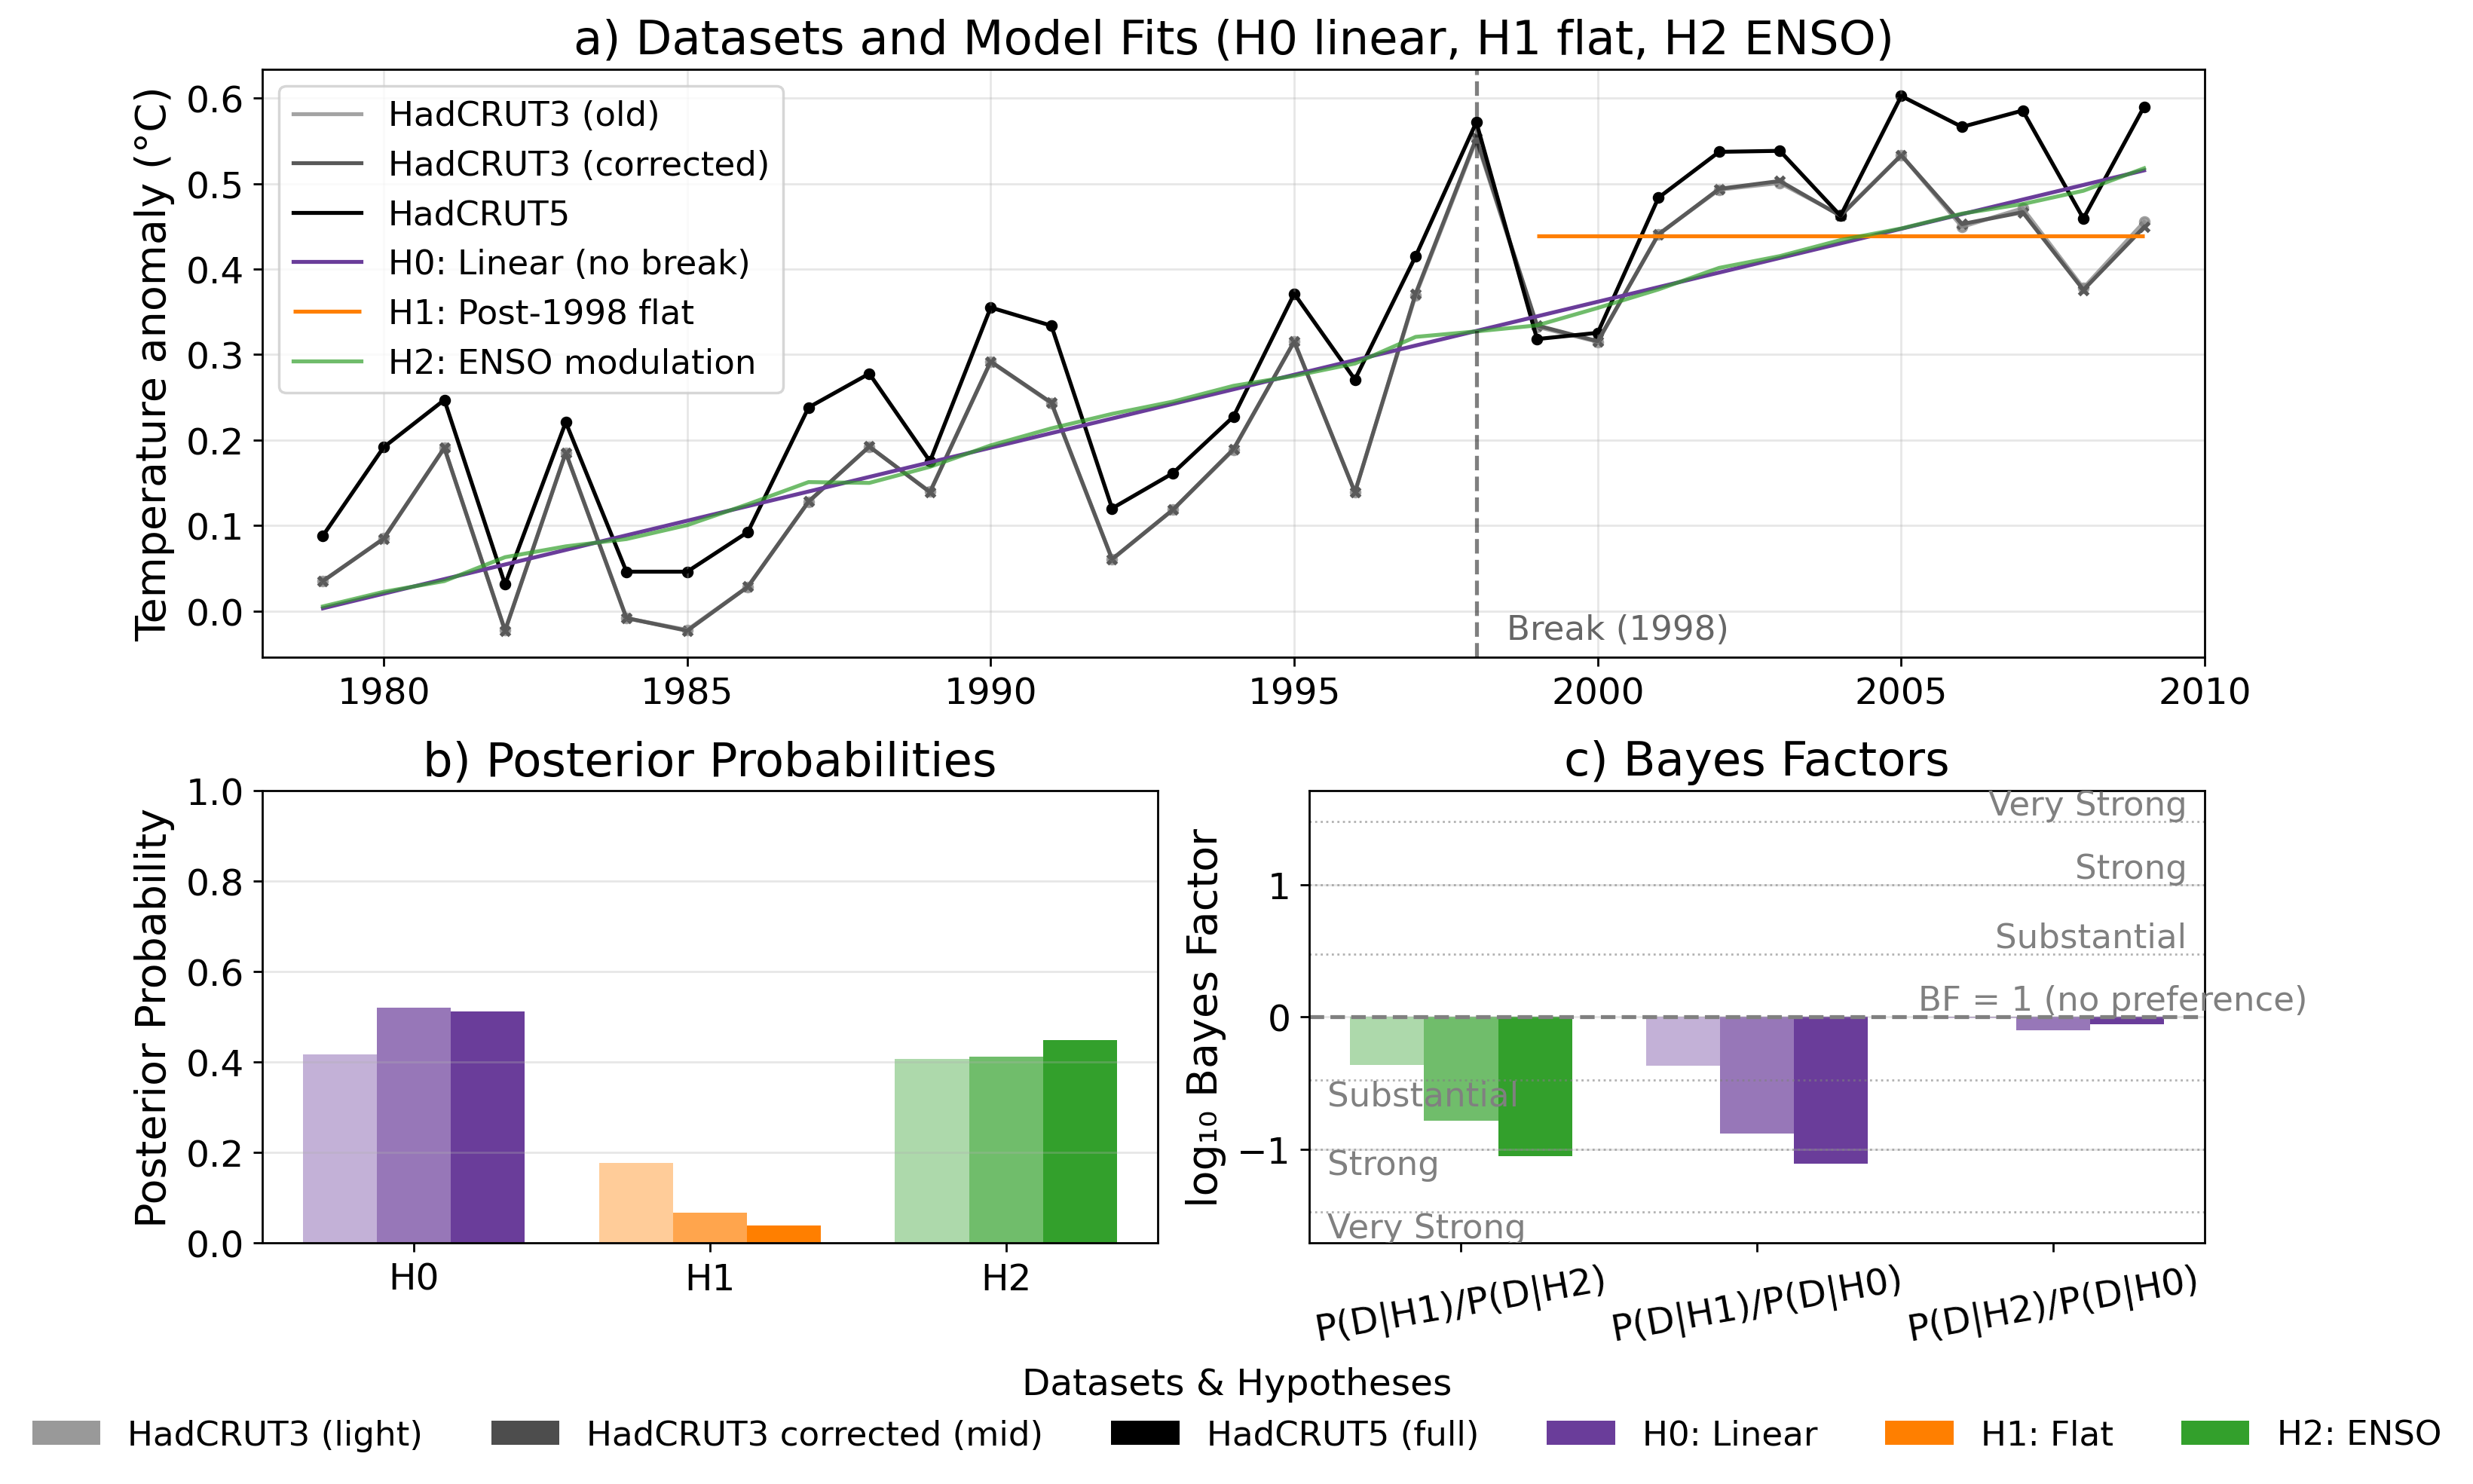

In [22]:
# === FONT SETTINGS ===
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 16
TICK_FONTSIZE  = 14
LEGEND_FONTSIZE = 13

# === Colors for hypotheses ===
H_COL = {"H0": "#6a3d9a",  # purple  (Linear trend)
         "H1": "#ff7f00",  # orange  (Flattening after 1998)
         "H2": "#33a02c"}  # green   (ENSO modulation)

# Dataset base greys / black for top panel
COL_H3_OLD  = (0.55, 0.55, 0.55)
COL_H3_CORR = (0.35, 0.35, 0.35)
COL_H5      = (0.00, 0.00, 0.00)

def lighten(hex_color, amount=0.5):
    r, g, b = to_rgb(hex_color)
    r = r + (1 - r) * amount
    g = g + (1 - g) * amount
    b = b + (1 - b) * amount
    return (r, g, b)

def parse_hypotheses(label):
    hs = re.findall(r"H\d+", label)
    if len(hs) < 2:
        raise ValueError(f"Could not parse hypothesis pair from label: {label}")
    return hs[0], hs[1]

def bf_winner_color(label, value, variant="full"):
    num, den = parse_hypotheses(label)
    base = H_COL[num] if value > 1 else H_COL[den]
    if variant == "light":
        return lighten(base, 0.60)
    if variant == "mid":
        return lighten(base, 0.30)
    return base

def get_prob(dct, h_label):
    i = int(h_label[1])
    return dct.get(i, dct.get(str(i), dct.get(h_label, 0)))

# --- Arrange data
H_ORDER = ["H0", "H1", "H2"]
probs_h3      = [get_prob(model_probs,          h) for h in H_ORDER]
probs_h3_corr = [get_prob(model_probs_h3_corr,  h) for h in H_ORDER]
probs_h5      = [get_prob(model_probs_h5,       h) for h in H_ORDER]

cols_h3_post      = [lighten(H_COL[h], 0.60) for h in H_ORDER]
cols_h3_corr_post = [lighten(H_COL[h], 0.30) for h in H_ORDER]
cols_h5_post      = [H_COL[h] for h in H_ORDER]

BF_ORDER = [k for k in list(BFs.keys()) if k in BFs_h3_corr and k in BFs_h5]
bf_vals_h3      = [BFs[k]         for k in BF_ORDER]
bf_vals_h3_corr = [BFs_h3_corr[k] for k in BF_ORDER]
bf_vals_h5      = [BFs_h5[k]      for k in BF_ORDER]
log_bf_h3      = np.log10(bf_vals_h3)
log_bf_h3_corr = np.log10(bf_vals_h3_corr)
log_bf_h5      = np.log10(bf_vals_h5)
cols_h3_bf      = [bf_winner_color(k, v, "light") for k, v in zip(BF_ORDER, bf_vals_h3)]
cols_h3_corr_bf = [bf_winner_color(k, v, "mid")   for k, v in zip(BF_ORDER, bf_vals_h3_corr)]
cols_h5_bf      = [bf_winner_color(k, v, "full")  for k, v in zip(BF_ORDER, bf_vals_h5)]

# === Figure Layout ===
fig = plt.figure(figsize=(12, 8), constrained_layout=True, dpi=250)
gs = GridSpec(2, 2, figure=fig, height_ratios=[1.3, 1.0])
ax_top = fig.add_subplot(gs[0, :])
axL    = fig.add_subplot(gs[1, 0])
axR    = fig.add_subplot(gs[1, 1])

# --- TOP: Datasets & Model Fits ---
ax_top.plot(years, temp, color=COL_H3_OLD, label='HadCRUT3 (old)', alpha=0.8)
ax_top.scatter(years, temp, color=COL_H3_OLD, s=12, alpha=0.8)
ax_top.plot(years, temp_corr, color=COL_H3_CORR, label='HadCRUT3 (corrected)')
ax_top.scatter(years, temp_corr, color=COL_H3_CORR, s=12, marker='x')
ax_top.plot(t_year, temp_hadCRUT5, color=COL_H5, label='HadCRUT5')
ax_top.scatter(t_year, temp_hadCRUT5, color=COL_H5, s=12)

# Add model fits
ax_top.plot(years, X_full @ beta_full, color=H_COL["H0"], linestyle='-', label='H0: Linear (no break)')
ax_top.hlines(y=np.mean(temp_corr[years > 1998]), xmin=1999, xmax=2009,
              color=H_COL["H1"], linestyle='-', label='H1: Post-1998 flat')

try:
    ax_top.plot(years, enso_fit_h3, color=H_COL["H2"], alpha=0.7, label='H2: ENSO modulation')
except Exception:
    pass

ax_top.axvline(x=1998, color='k', linestyle='--', alpha=0.5)
ax_top.text(1998.5, ax_top.get_ylim()[0] + 0.02*(ax_top.get_ylim()[1]-ax_top.get_ylim()[0]),
            'Break (1998)', va='bottom', ha='left', color='k', alpha=0.6, fontsize=LEGEND_FONTSIZE)
ax_top.set_xlim(1978, 2010)
ax_top.set_ylabel('Temperature anomaly (°C)', fontsize=LABEL_FONTSIZE)
ax_top.set_title("a) Datasets and Model Fits (H0 linear, H1 flat, H2 ENSO)", fontsize=TITLE_FONTSIZE)
ax_top.tick_params(axis='both', labelsize=TICK_FONTSIZE)
ax_top.legend(loc='upper left', fontsize=LEGEND_FONTSIZE)
ax_top.grid(alpha=0.3)

# --- BOTTOM-LEFT: Posterior Probabilities ---
x = np.arange(len(H_ORDER))
w = 0.25
axL.bar(x - w, probs_h3,      width=w, color=cols_h3_post)
axL.bar(x,      probs_h3_corr, width=w, color=cols_h3_corr_post)
axL.bar(x + w,  probs_h5,      width=w, color=cols_h5_post)
axL.set_xticks(x, H_ORDER)
axL.set_ylim(0, 1)
axL.set_ylabel("Posterior Probability", fontsize=LABEL_FONTSIZE)
axL.set_title("b) Posterior Probabilities", fontsize=TITLE_FONTSIZE)
axL.tick_params(axis='both', labelsize=TICK_FONTSIZE)
axL.grid(axis='y', alpha=0.3)

# --- BOTTOM-RIGHT: Bayes Factors (log10) ---
x_bf = np.arange(len(BF_ORDER))
axR.bar(x_bf - w, log_bf_h3,      width=w, color=cols_h3_bf)
axR.bar(x_bf,      log_bf_h3_corr, width=w, color=cols_h3_corr_bf)
axR.bar(x_bf + w,  log_bf_h5,      width=w, color=cols_h5_bf)
axR.axhline(0, color='gray', linestyle='--')
axR.text(0.68, 0.001, "BF = 1 (no preference)",
         transform=axR.get_yaxis_transform(), ha='left', va='bottom',
         fontsize=LEGEND_FONTSIZE, color='gray')

# Jeffreys thresholds
pos = [np.log10(3), np.log10(10), np.log10(30), np.log10(100)]
neg = [-p for p in pos]
labels_j = ["Substantial", "Strong", "Very Strong", "Decisive"]
max_abs = max(1.0, np.nanmax(np.abs(np.r_[log_bf_h3, log_bf_h3_corr, log_bf_h5])))
ylim = min(max_abs + 0.6, 3.0)
axR.set_ylim(-ylim, ylim)
for t, lab in zip(pos, labels_j):
    if t <= ylim:
        axR.axhline(t, color='gray', linestyle=':', alpha=0.6, lw=0.8)
        axR.text(0.98, t, lab, transform=axR.get_yaxis_transform(),
                 ha='right', va='bottom', fontsize=LEGEND_FONTSIZE, color='gray', clip_on=True)
for t, lab in zip(neg, labels_j):
    if t >= -ylim:
        axR.axhline(t, color='gray', linestyle=':', alpha=0.6, lw=0.8)
        axR.text(0.02, t, lab, transform=axR.get_yaxis_transform(),
                 ha='left', va='top', fontsize=LEGEND_FONTSIZE, color='gray', clip_on=True)

axR.set_xticks(x_bf, BF_ORDER, rotation=10)
axR.set_ylabel("log₁₀ Bayes Factor", fontsize=LABEL_FONTSIZE)
axR.set_title("c) Bayes Factors", fontsize=TITLE_FONTSIZE)
axR.tick_params(axis='both', labelsize=TICK_FONTSIZE)
axR.grid(axis='y', alpha=0.3)

# --- Combined Legend ---
plt.tight_layout(rect=[0, 0.08, 1, 1])
fig.legend(
    handles=[
        Patch(facecolor=lighten("#000000", 0.60), label="HadCRUT3 (light)"),
        Patch(facecolor=lighten("#000000", 0.30), label="HadCRUT3 corrected (mid)"),
        Patch(facecolor="#000000", label="HadCRUT5 (full)"),
        Patch(facecolor=H_COL["H0"], label="H0: Linear"),
        Patch(facecolor=H_COL["H1"], label="H1: Flat"),
        Patch(facecolor=H_COL["H2"], label="H2: ENSO"),
    ],
    loc="lower center",
    ncol=6,
    frameon=False,
    bbox_to_anchor=(0.5, 0.01),
    fontsize=LEGEND_FONTSIZE,
    title="Datasets & Hypotheses",
    title_fontsize=LEGEND_FONTSIZE + 1
)

plt.show()
